In [1]:
#!/usr/bin/env python3
"""
Fixed Multi-Pattern Patch Loader for NRSC Challenge
Handles both batch files and individual patch files
"""

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
import matplotlib.pyplot as plt
import warnings
import gc
from collections import defaultdict
warnings.filterwarnings('ignore')

class FixedMultiScenePatchLoader:
    """
    Fixed patch loader that handles multiple file patterns:
    - patch_batch_*.npz (batch files)
    - patch_*.npz (individual files)
    """
    
    def __init__(self, base_patches_dir="/kaggle/input/toa-mask-patches"):
        self.base_dir = Path(base_patches_dir)
        self.scene_folders = []
        self.patch_stats = {}
        
        print("🔧 Fixed Multi-Pattern Patch Loader for NRSC Challenge")
        print(f"   Base directory: {self.base_dir}")
        
        # Discover all scene folders with flexible pattern matching
        self.discover_all_patterns()
        
    def discover_all_patterns(self):
        """Discover folders with any supported patch pattern"""
        print("🔍 Discovering scene folders with flexible pattern matching...")
        
        if not self.base_dir.exists():
            print(f"❌ Base directory does not exist: {self.base_dir}")
            return
        
        # Check each folder for any patch files
        for folder in self.base_dir.iterdir():
            if not folder.is_dir():
                continue
                
            folder_name = folder.name
            
            # Check for batch pattern in root
            batch_files = list(folder.glob("patch_batch_*.npz"))
            # Check for individual pattern in root
            individual_files = list(folder.glob("patch_*.npz"))
            # Check for alternative individual pattern in root
            numbered_files = list(folder.glob("patch_[0-9]*.npz"))
            
            # Also check in 'patches' subdirectory
            patches_subdir = folder / "patches"
            if patches_subdir.exists() and patches_subdir.is_dir():
                batch_files.extend(list(patches_subdir.glob("patch_batch_*.npz")))
                individual_files.extend(list(patches_subdir.glob("patch_*.npz")))
                numbered_files.extend(list(patches_subdir.glob("patch_[0-9]*.npz")))
            
            total_patch_files = len(batch_files) + len(individual_files) + len(numbered_files)
            
            if total_patch_files > 0:
                self.scene_folders.append(folder)
                
                # Determine pattern type and location
                if batch_files:
                    pattern_type = "batch"
                    file_count = len(batch_files)
                elif individual_files:
                    pattern_type = "individual"
                    file_count = len(individual_files)
                elif numbered_files:
                    pattern_type = "numbered"
                    file_count = len(numbered_files)
                else:
                    pattern_type = "unknown"
                    file_count = 0
                
                # Check if patches are in subdirectory
                patches_in_subdir = patches_subdir.exists() and any([
                    list(patches_subdir.glob("patch_batch_*.npz")),
                    list(patches_subdir.glob("patch_*.npz")),
                    list(patches_subdir.glob("patch_[0-9]*.npz"))
                ])
                
                location = "subdirectory" if patches_in_subdir else "root"
                print(f"   ✅ {folder_name}: {file_count} files ({pattern_type} pattern, {location})")
                
                # Store pattern info
                self.patch_stats[folder_name] = {
                    'pattern_type': pattern_type,
                    'file_count': file_count,
                    'patches_in_subdir': patches_in_subdir,
                    'total_patches': 'Unknown'
                }
                
                # Try to load patch info
                info_file = folder / "patch_info.json"
                if info_file.exists():
                    try:
                        with open(info_file, 'r') as f:
                            info = json.load(f)
                        self.patch_stats[folder_name].update(info)
                    except:
                        pass
        
        print(f"\n📊 Discovery Summary:")
        print(f"   Total scene folders found: {len(self.scene_folders)}")
        
        # Group by pattern type
        pattern_counts = defaultdict(int)
        for stats in self.patch_stats.values():
            pattern_counts[stats['pattern_type']] += 1
        
        for pattern, count in pattern_counts.items():
            print(f"   {pattern.capitalize()} pattern: {count} folders")
    
    def load_patches_batch_pattern(self, scene_folder, max_patches=1000):
        """Load patches from batch files (patch_batch_*.npz)"""
        # Check both root and patches subdirectory
        batch_files = sorted(scene_folder.glob("patch_batch_*.npz"))
        patches_subdir = scene_folder / "patches"
        if patches_subdir.exists():
            batch_files.extend(sorted(patches_subdir.glob("patch_batch_*.npz")))
        
        all_patches = []
        all_labels = []
        patches_loaded = 0
        
        for batch_file in batch_files:
            if patches_loaded >= max_patches:
                break
                
            try:
                batch_data = np.load(batch_file)
                patches = batch_data['patches']
                labels = batch_data['labels']
                
                remaining_quota = max_patches - patches_loaded
                if len(patches) > remaining_quota:
                    patches = patches[:remaining_quota]
                    labels = labels[:remaining_quota]
                
                all_patches.append(patches)
                all_labels.append(labels)
                patches_loaded += len(patches)
                
            except Exception as e:
                print(f"     ⚠️ Error loading {batch_file.name}: {e}")
                continue
        
        if all_patches:
            return np.concatenate(all_patches, axis=0), np.concatenate(all_labels, axis=0)
        else:
            return None, None
    
    def load_patches_individual_pattern(self, scene_folder, max_patches=1000):
        """Load patches from individual files (patch_*.npz)"""
        # Check both root and patches subdirectory
        individual_files = sorted(scene_folder.glob("patch_*.npz"))
        numbered_files = sorted(scene_folder.glob("patch_[0-9]*.npz"))
        
        patches_subdir = scene_folder / "patches"
        if patches_subdir.exists():
            individual_files.extend(sorted(patches_subdir.glob("patch_*.npz")))
            numbered_files.extend(sorted(patches_subdir.glob("patch_[0-9]*.npz")))
        
        # Use whichever pattern has more files
        if len(individual_files) >= len(numbered_files):
            patch_files = individual_files
        else:
            patch_files = numbered_files
        
        all_patches = []
        all_labels = []
        patches_loaded = 0
        
        for patch_file in patch_files:
            if patches_loaded >= max_patches:
                break
                
            try:
                patch_data = np.load(patch_file)
                
                # Handle different key names
                if 'patch' in patch_data.keys() and 'label' in patch_data.keys():
                    patch = patch_data['patch']
                    label = patch_data['label']
                elif 'patches' in patch_data.keys() and 'labels' in patch_data.keys():
                    patch = patch_data['patches']
                    label = patch_data['labels']
                    # Handle single patch vs batch
                    if len(patch.shape) == 4:  # Batch dimension
                        patch = patch[0]
                        label = label[0]
                elif 'toa_data' in patch_data.keys() and 'labels' in patch_data.keys():
                    # Handle the new format with 'toa_data'
                    patch = patch_data['toa_data']
                    label = patch_data['labels']
                elif 'data' in patch_data.keys() and 'target' in patch_data.keys():
                    patch = patch_data['data']
                    label = patch_data['target']
                else:
                    print(f"     ⚠️ Unknown format in {patch_file.name}: {list(patch_data.keys())}")
                    continue
                
                # Ensure patch has correct shape
                if len(patch.shape) == 3:  # (H, W, C)
                    all_patches.append(patch)
                    all_labels.append(label)
                    patches_loaded += 1
                
            except Exception as e:
                print(f"     ⚠️ Error loading {patch_file.name}: {e}")
                continue
        
        if all_patches:
            return np.array(all_patches), np.array(all_labels)
        else:
            return None, None
    
    def load_scene_patches_flexible(self, scene_folder, max_patches_per_scene=600):
        """Load patches with flexible pattern detection"""
        folder_name = scene_folder.name
        pattern_type = self.patch_stats[folder_name]['pattern_type']
        patches_in_subdir = self.patch_stats[folder_name].get('patches_in_subdir', False)
        
        location_info = "subdirectory" if patches_in_subdir else "root"
        print(f"   📂 Loading {folder_name} ({pattern_type} pattern, {location_info})")
        
        # Load based on pattern type
        if pattern_type == "batch":
            patches, labels = self.load_patches_batch_pattern(scene_folder, max_patches_per_scene)
        elif pattern_type in ["individual", "numbered"]:
            patches, labels = self.load_patches_individual_pattern(scene_folder, max_patches_per_scene)
        else:
            print(f"     ❌ Unknown pattern type: {pattern_type}")
            return None, None, None
        
        if patches is None:
            print(f"     ❌ No patches loaded")
            return None, None, None
        
        print(f"     ✅ Loaded {len(patches)} patches")
        
        # Quality filtering
        valid_indices, quality_stats = self.analyze_patch_quality(patches, labels, folder_name)
        
        if not valid_indices:
            print(f"     ❌ No valid patches after quality filtering")
            return None, None, None
        
        # Filter patches
        filtered_patches = patches[valid_indices]
        filtered_labels = labels[valid_indices]
        
        print(f"     ✅ {len(filtered_patches)} valid patches after filtering")
        
        return filtered_patches, filtered_labels, quality_stats
    
    def analyze_patch_quality(self, patches, labels, scene_name):
        """Analyze patch quality and remove blanks"""
        valid_indices = []
        quality_stats = {
            'total': len(patches),
            'blank_patches': 0,
            'low_variance': 0,
            'all_zero': 0,
            'invalid_labels': 0,
            'valid': 0
        }
        
        for i in range(len(patches)):
            patch = patches[i]
            label = labels[i]
            
            # Check for blank patches
            if np.max(patch) < 0.001:
                quality_stats['all_zero'] += 1
                continue
            
            # Check for low variance
            if np.var(patch) < 1e-6:
                quality_stats['low_variance'] += 1
                continue
            
            # Check for invalid labels
            unique_labels = np.unique(label)
            if not all(lab in [0, 1, 2] for lab in unique_labels):
                quality_stats['invalid_labels'] += 1
                continue
            
            # Check for very dark patches
            if np.mean(patch) < 0.005:
                quality_stats['blank_patches'] += 1
                continue
            
            # Patch is valid
            valid_indices.append(i)
            quality_stats['valid'] += 1
        
        return valid_indices, quality_stats
    
    def load_all_scenes(self, max_patches_per_scene=600, balance_classes=True):
        """Load all scenes with flexible pattern handling"""
        print(f"🌍 Loading patches from all {len(self.scene_folders)} scenes...")
        
        all_patches = []
        all_labels = []
        scene_stats = {}
        
        for i, scene_folder in enumerate(self.scene_folders, 1):
            print(f"\n📂 Processing scene {i}/{len(self.scene_folders)}: {scene_folder.name}")
            
            try:
                patches, labels, quality_stats = self.load_scene_patches_flexible(
                    scene_folder, max_patches_per_scene
                )
                
                if patches is not None:
                    all_patches.append(patches)
                    all_labels.append(labels)
                    scene_stats[scene_folder.name] = quality_stats
                    
                    # Show class distribution
                    unique, counts = np.unique(labels, return_counts=True)
                    class_dist = {int(u): int(c) for u, c in zip(unique, counts)}
                    print(f"     Class distribution: {class_dist}")
                
            except Exception as e:
                print(f"     ❌ Error processing {scene_folder.name}: {e}")
                continue
        
        if not all_patches:
            raise ValueError("No valid patches loaded from any scene!")
        
        # Combine all patches
        print(f"\n📊 Combining patches from {len(all_patches)} successful scenes...")
        final_patches = np.concatenate(all_patches, axis=0)
        final_labels = np.concatenate(all_labels, axis=0)
        
        print(f"   Total patches before balancing: {len(final_patches)}")
        
        # Balance classes if requested
        if balance_classes:
            final_patches, final_labels = self.balance_dataset(final_patches, final_labels)
        
        # Final statistics
        unique, counts = np.unique(final_labels, return_counts=True)
        total_patches = len(final_patches)
        
        print(f"\n✅ Final unified dataset:")
        print(f"   Scenes processed: {len(all_patches)}")
        print(f"   Total patches: {total_patches:,}")
        print(f"   Memory usage: ~{final_patches.nbytes / 1024 / 1024:.0f}MB")
        
        class_names = {0: "NOCLOUD", 1: "CLOUD", 2: "SHADOW"}
        for label, count in zip(unique, counts):
            percentage = count / total_patches * 100
            print(f"   {class_names[label]}: {count:,} patches ({percentage:.1f}%)")
        
        # Clean up
        del all_patches, all_labels
        gc.collect()
        
        return final_patches, final_labels, scene_stats
    
    def balance_dataset(self, patches, labels, target_samples_per_class=1500):
        """Balance dataset with memory efficiency to avoid kernel restart"""
        print(f"⚖️ Balancing dataset (target: {target_samples_per_class} per class)...")
        print(f"   Input data: {len(patches)} patches, {patches.nbytes / 1024 / 1024:.0f}MB")
        
        balanced_patches = []
        balanced_labels = []
        
        for class_id in [0, 1, 2]:
            print(f"   Processing class {class_id}...")
            
            # Find indices instead of creating copies
            class_indices = np.where(labels == class_id)[0]
            
            print(f"     Class {class_id}: {len(class_indices)} available")
            
            if len(class_indices) == 0:
                print(f"     ⚠️ No patches for class {class_id}")
                continue
            
            # Sample indices
            if len(class_indices) >= target_samples_per_class:
                sampled_indices = np.random.choice(class_indices, target_samples_per_class, replace=False)
            else:
                sampled_indices = class_indices
                print(f"     Using all {len(class_indices)} patches")
            
            # Extract patches and labels using indices
            sampled_patches = patches[sampled_indices]
            sampled_labels = labels[sampled_indices]
            
            balanced_patches.append(sampled_patches)
            balanced_labels.append(sampled_labels)
            
            # Force garbage collection after each class
            gc.collect()
        
        print("   Combining balanced classes...")
        
        # Combine balanced data
        final_patches = np.concatenate(balanced_patches, axis=0)
        final_labels = np.concatenate(balanced_labels, axis=0)
        
        # Clear intermediate arrays
        del balanced_patches, balanced_labels
        gc.collect()
        
        print("   Shuffling dataset...")
        
        # Shuffle with memory efficiency
        shuffle_indices = np.random.permutation(len(final_patches))
        final_patches = final_patches[shuffle_indices]
        final_labels = final_labels[shuffle_indices]
        
        print(f"✅ Dataset balanced: {len(final_patches)} total patches ({final_patches.nbytes / 1024 / 1024:.0f}MB)")
        
        return final_patches, final_labels

class UnifiedCloudDataset(Dataset):
    """PyTorch Dataset for unified cloud detection"""
    
    def __init__(self, patches, labels, augment=False):
        self.patches = patches.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.augment = augment
        
        print(f"📦 Unified Cloud Dataset:")
        print(f"   Patches: {self.patches.shape}")
        print(f"   Labels: {self.labels.shape}")
        print(f"   Augmentation: {augment}")
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        label = self.labels[idx]
        
        # Data augmentation
        if self.augment:
            if np.random.random() > 0.5:
                patch = np.fliplr(patch)
                label = np.fliplr(label)
            if np.random.random() > 0.5:
                patch = np.flipud(patch)
                label = np.flipud(label)
            if np.random.random() > 0.5:
                k = np.random.randint(1, 4)
                patch = np.rot90(patch, k, axes=(0, 1))
                label = np.rot90(label, k, axes=(0, 1))
        
        # Convert to PyTorch format
        patch_tensor = torch.from_numpy(patch.copy()).permute(2, 0, 1)  # (C, H, W)
        label_tensor = torch.from_numpy(label.copy()).long()
        
        return patch_tensor, label_tensor

def save_processed_data(patches, labels, stats, filename="nrsc_processed_data.npz"):
    """Save processed data to avoid reprocessing after kernel restart"""
    print(f"💾 Saving processed data to {filename}...")
    
    np.savez_compressed(
        filename,
        patches=patches,
        labels=labels,
        stats=str(stats),  # Convert dict to string for saving
        processing_info={
            'total_scenes': len(stats),
            'total_patches': len(patches),
            'patch_shape': patches.shape[1:],
            'classes': {'0': 'NOCLOUD', '1': 'CLOUD', '2': 'SHADOW'}
        }
    )
    
    file_size = Path(filename).stat().st_size / 1024 / 1024
    print(f"✅ Saved {len(patches):,} patches ({file_size:.0f}MB)")
    
def load_processed_data(filename="nrsc_processed_data.npz"):
    """Load previously processed data"""
    if not Path(filename).exists():
        print(f"❌ File {filename} not found")
        return None, None, None
        
    print(f"📁 Loading processed data from {filename}...")
    
    data = np.load(filename, allow_pickle=True)
    patches = data['patches']
    labels = data['labels']
    stats = eval(data['stats'].item())  # Convert string back to dict
    
    print(f"✅ Loaded {len(patches):,} patches")
    return patches, labels, stats

def create_training_pipeline_from_saved_data(filename="nrsc_processed_data.npz"):
    """Create training pipeline from saved data"""
    patches, labels, stats = load_processed_data(filename)
    
    if patches is None:
        print("❌ No saved data found. Need to process first.")
        return None, None
    
    # Create datasets
    n_samples = len(patches)
    n_train = int(n_samples * 0.8)
    
    indices = np.random.permutation(n_samples)
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]
    
    train_dataset = UnifiedCloudDataset(
        patches[train_indices], 
        labels[train_indices], 
        augment=True
    )
    
    val_dataset = UnifiedCloudDataset(
        patches[val_indices], 
        labels[val_indices], 
        augment=False
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=1)
    
    print(f"🎯 Training pipeline recreated from saved data:")
    print(f"   Training samples: {len(train_dataset):,}")
    print(f"   Validation samples: {len(val_dataset):,}")
    
    return train_loader, val_loader

def load_all_nrsc_patches_memory_efficient(base_dir="/kaggle/input/toa-mask-patches"):
    """Memory-efficient version to prevent kernel restart"""
    print("🚀 Loading All NRSC Patches (Memory-Efficient)")
    print("="*70)
    
    # Create loader
    loader = FixedMultiScenePatchLoader(base_dir)
    
    # Load with reduced memory usage
    patches, labels, stats = loader.load_all_scenes(
        max_patches_per_scene=400,  # Reduced from
        balance_classes=True
    )
    
    print(f"\n💾 Memory optimization:")
    print(f"   Patches memory: {patches.nbytes / 1024 / 1024:.0f}MB")
    print(f"   Labels memory: {labels.nbytes / 1024 / 1024:.0f}MB")
    
    # Save processed data for future use
    save_processed_data(patches, labels, stats)
    
    # Create datasets with smaller batch size
    n_samples = len(patches)
    n_train = int(n_samples * 0.8)
    
    indices = np.random.permutation(n_samples)
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]
    
    print(f"   Creating training dataset...")
    train_dataset = UnifiedCloudDataset(
        patches[train_indices], 
        labels[train_indices], 
        augment=True
    )
    
    print(f"   Creating validation dataset...")
    val_dataset = UnifiedCloudDataset(
        patches[val_indices], 
        labels[val_indices], 
        augment=False
    )
    
    # Create data loaders with smaller batch size to save memory
    train_loader = DataLoader(
        train_dataset, 
        batch_size=4,  # Reduced from 8
        shuffle=True, 
        num_workers=1,  # Reduced from 2
        pin_memory=False  # Disable to save memory
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=4,  # Reduced from 8
        shuffle=False, 
        num_workers=1,  # Reduced from 2  
        pin_memory=False  # Disable to save memory
    )
    
    print(f"\n🎯 Memory-Efficient Training Pipeline Ready:")
    print(f"   Training samples: {len(train_dataset):,}")
    print(f"   Validation samples: {len(val_dataset):,}")
    print(f"   Total scenes processed: {len([s for s in stats.keys()])}")
    print(f"   Batch size: 4 (reduced for memory efficiency)")
    
    return train_loader, val_loader, patches, labels, stats

def test_subdirectory_detection(base_dir="/kaggle/input/toa-mask-patches"):
    """Test function to verify subdirectory detection works"""
    print("🧪 Testing Subdirectory Detection")
    print("="*50)
    
    # Create a simple loader just for testing
    loader = FixedMultiScenePatchLoader(base_dir)
    
    # Show what was found
    print(f"\n📊 Found {len(loader.scene_folders)} total scene folders")
    
    # Check specifically for the problematic folders
    problematic_folders = [
        "RAF23MAR2025043024009400045",
        "RAF13NOV2024041177009200044", 
        "R2F15JUN2024068272009300044"
    ]
    
    found_folders = [folder.name for folder in loader.scene_folders]
    
    print(f"\n🔍 Checking for previously missing folders:")
    for folder_name in problematic_folders:
        if folder_name in found_folders:
            print(f"   ✅ {folder_name} - FOUND!")
            stats = loader.patch_stats[folder_name]
            print(f"      Pattern: {stats['pattern_type']}")
            print(f"      Files: {stats['file_count']}")
            print(f"      Location: {'subdirectory' if stats.get('patches_in_subdir', False) else 'root'}")
        else:
            print(f"   ❌ {folder_name} - Still missing")
    
    print(f"\n🎯 Total scenes that should be found: 20")
    print(f"🎯 Actually found: {len(loader.scene_folders)}")
    
    if len(loader.scene_folders) == 20:
        print("✅ SUCCESS: All 20 scenes found!")
    else:
        print("⚠️  Still missing some scenes")
    
    return loader

if __name__ == "__main__":
    print("🔧 NRSC Challenge Data Loader (Fixed & Memory-Efficient)")
    print("="*70)
    
    # Check if processed data already exists
    if Path("nrsc_processed_data.npz").exists():
        print("📁 Found previously processed data!")
        user_choice = input("Load from saved data? (y/n): ").lower().strip()
        
        if user_choice == 'y':
            print("📁 Loading from saved data...")
            train_loader, val_loader = create_training_pipeline_from_saved_data()
            if train_loader is not None:
                print("✅ Ready for training from saved data!")
            exit()
    
    # Test the subdirectory detection first
    test_loader = test_subdirectory_detection()
    
    if len(test_loader.scene_folders) >= 17:  # Accept 17+ scenes
        print(f"\n🚀 Found {len(test_loader.scene_folders)} scenes! Running memory-efficient loading...")
        
        try:
            # Use memory-efficient version to prevent kernel restart
            train_loader, val_loader, patches, labels, stats = load_all_nrsc_patches_memory_efficient()
            
            print("\n🎉 All patches loaded successfully!")
            print("✅ Ready for NRSC Challenge training!")
            
            # Show final statistics
            unique, counts = np.unique(labels, return_counts=True)
            total = len(labels)
            print(f"\n📊 Final Dataset Statistics:")
            class_names = {0: "NOCLOUD", 1: "CLOUD", 2: "SHADOW"}
            for label, count in zip(unique, counts):
                percentage = count / total * 100
                print(f"   {class_names[label]}: {count:,} patches ({percentage:.1f}%)")
                
        except Exception as e:
            print(f"\n❌ Error during loading: {e}")
            print("💡 If kernel restarted, rerun this script and load from saved data")
            
    else:
        print(f"\n⚠️ Only found {len(test_loader.scene_folders)} scenes (expected 20)")
        print("💡 Proceeding with available scenes for training")

🔧 NRSC Challenge Data Loader (Fixed & Memory-Efficient)
🧪 Testing Subdirectory Detection
🔧 Fixed Multi-Pattern Patch Loader for NRSC Challenge
   Base directory: /kaggle/input/toa-mask-patches
🔍 Discovering scene folders with flexible pattern matching...
   ✅ R2F27AUG2024069309009800054: 40 files (batch pattern, root)
   ✅ RAF10SEP2024040267010800054: 40 files (batch pattern, root)
   ✅ R2F30APR2024067624010300067: 40 files (batch pattern, root)
   ✅ RAF18AUG2024039941008900053: 40 files (batch pattern, root)
   ✅ RAF22JUN2024039131009200052: 40 files (batch pattern, root)
   ✅ RAF19JUL2024039514010700054: 40 files (batch pattern, root)
   ✅ RAF18MAY2025043819011000054: 40 files (batch pattern, root)
   ✅ RAF08MAY2024038491010700053: 40 files (batch pattern, root)
   ✅ R2F18JAN2025071363009800054: 40 files (batch pattern, root)
   ✅ R2F01JAN2025071113010900054: 40 files (batch pattern, root)
   ✅ R2F01SEP2024069380009900053: 40 files (batch pattern, root)
   ✅ RAF23MAR20250430240094000

🎨 Starting NRSC Dataset Visualization...
🎨 NRSC Patch Dataset Visualizer Initialized
📁 Data path: /kaggle/working/nrsc_processed_data.npz
📂 Loading processed patch data...
✅ Data loaded successfully:
   Patches shape: (4500, 256, 256, 3)
   Labels shape: (4500, 256, 256)
   Data type: float32
   Value range: [0.0000, 1.0000]

📊 Analyzing class distribution...
📈 Class distribution in patches:
   SHADOW (2): 543 patches (12.1%)
   CLOUD (1): 1,516 patches (33.7%)
   NOCLOUD (0): 2,441 patches (54.2%)
🎨 NRSC PATCH DATASET VISUALIZATION SUITE

📊 Creating dataset summary...


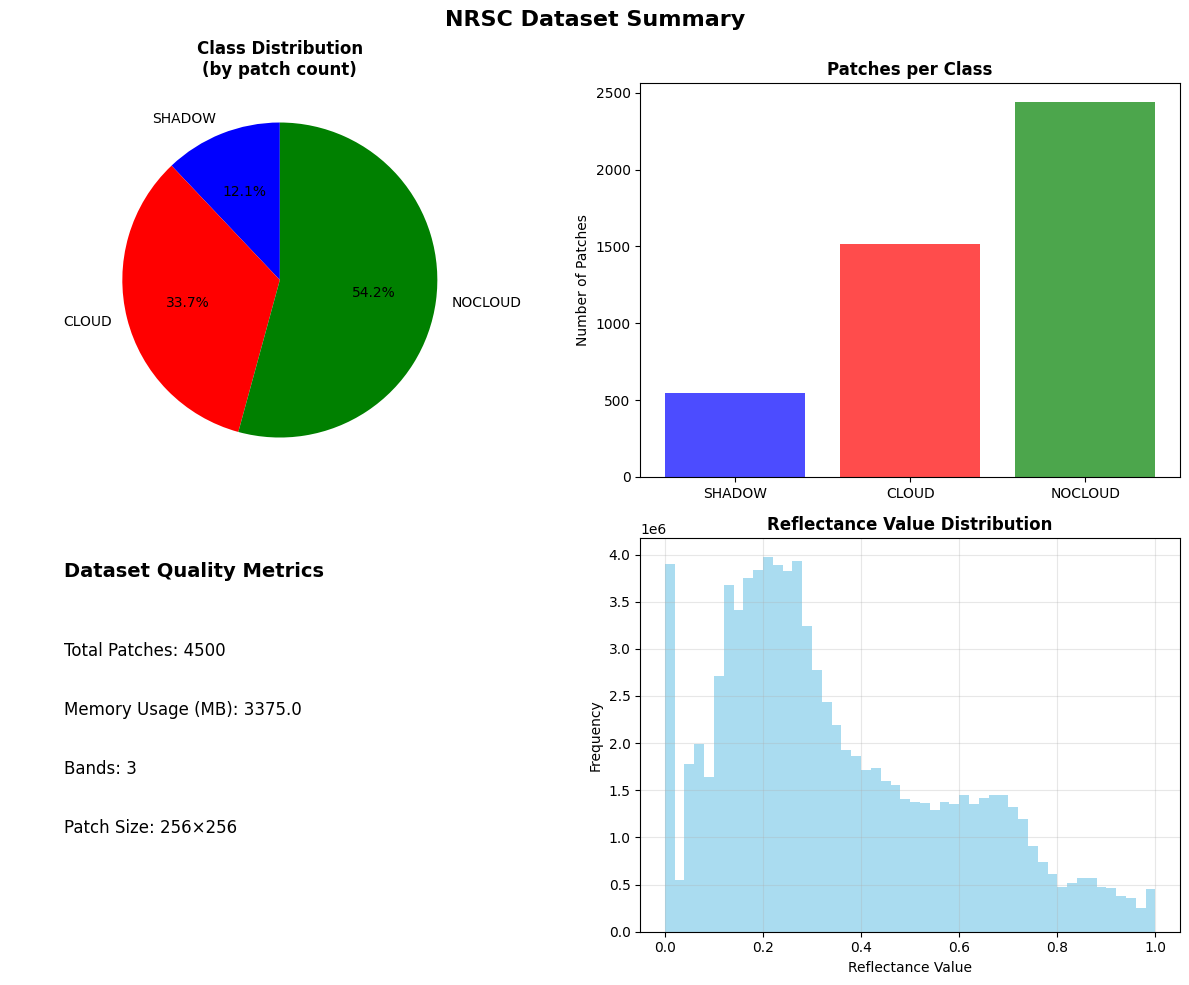

✅ Dataset summary saved: nrsc_dataset_summary.png

🎨 Visualizing 6 samples from class 0 (NOCLOUD)...


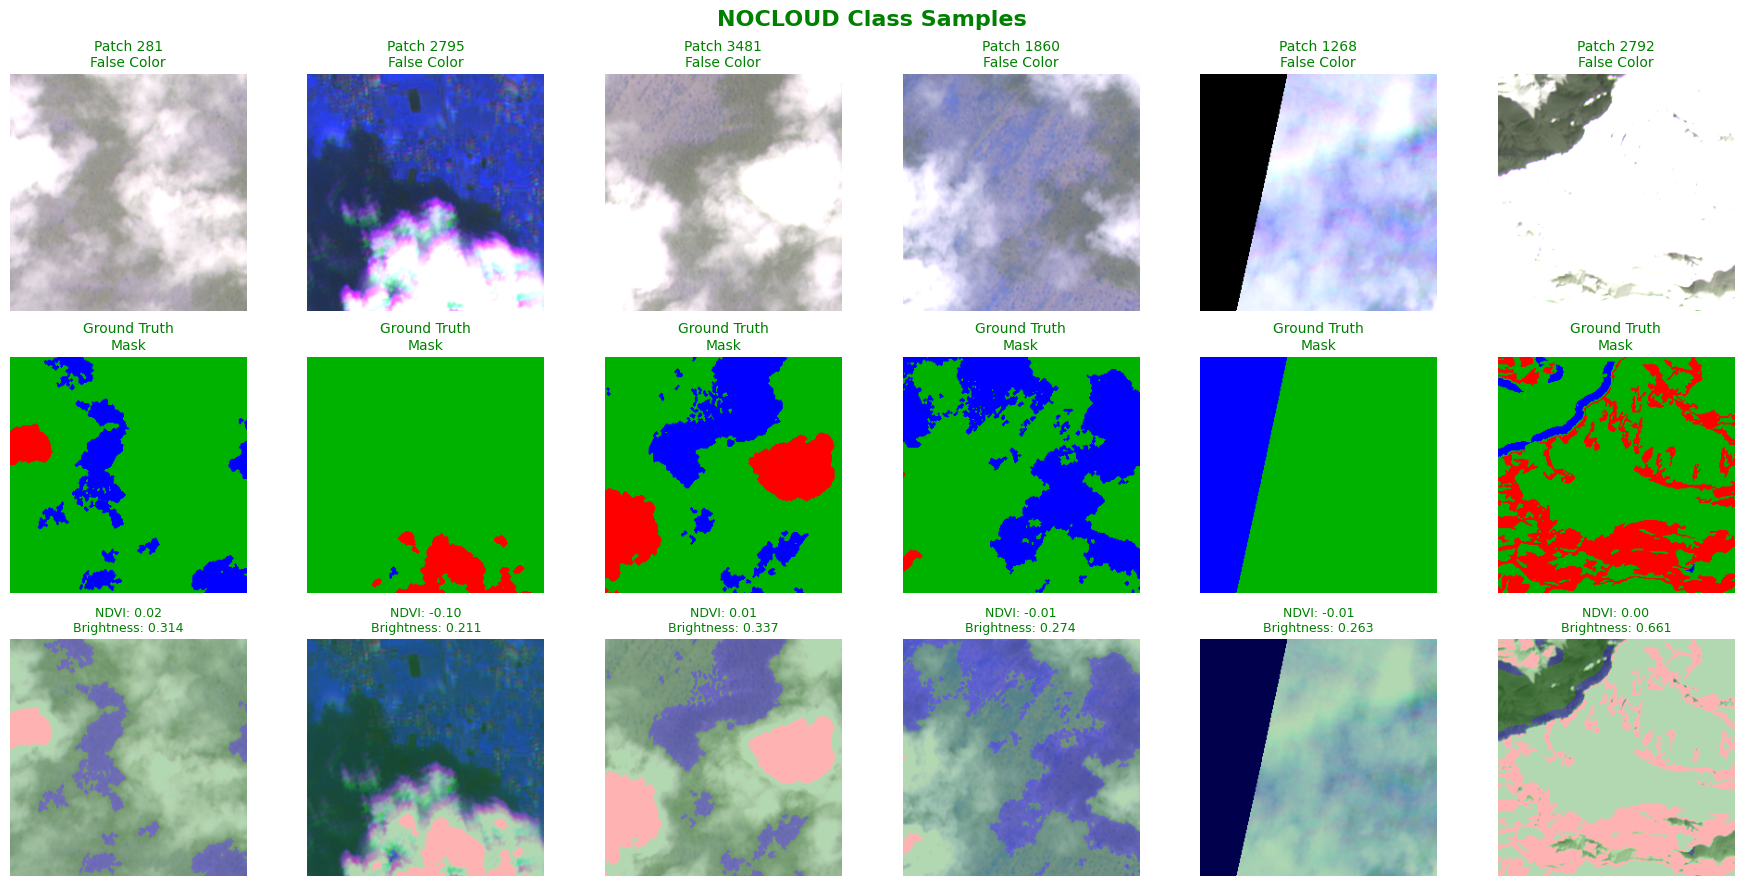

✅ Visualization saved: nrsc_nocloud_samples.png

🎨 Visualizing 6 samples from class 1 (CLOUD)...


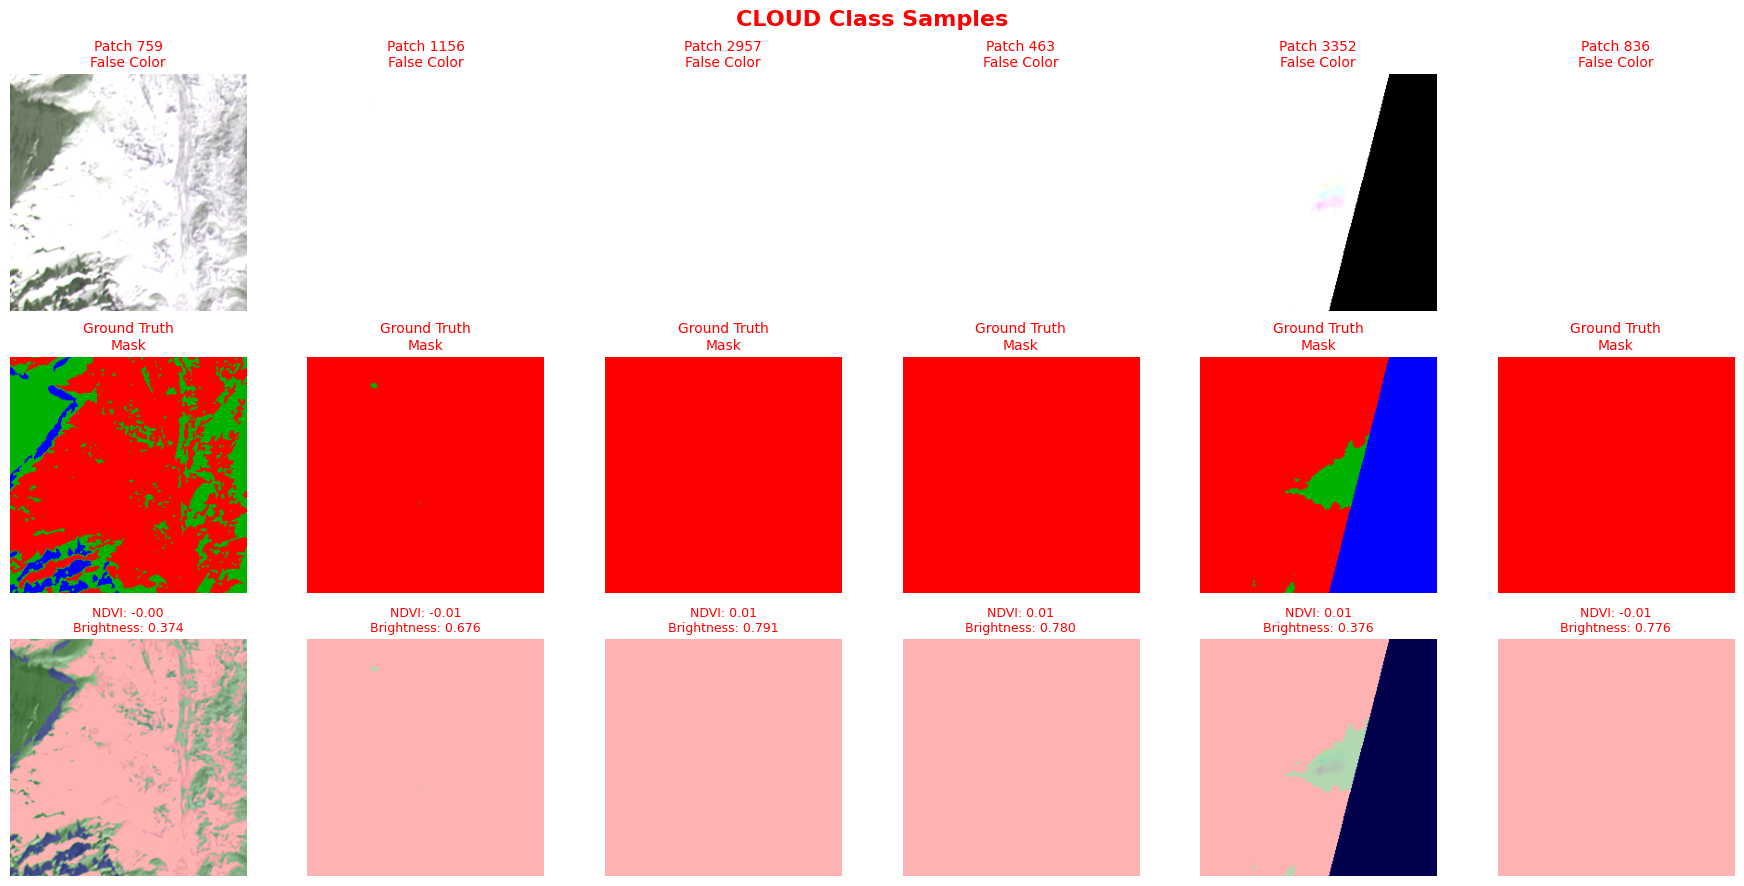

✅ Visualization saved: nrsc_cloud_samples.png

🎨 Visualizing 6 samples from class 2 (SHADOW)...


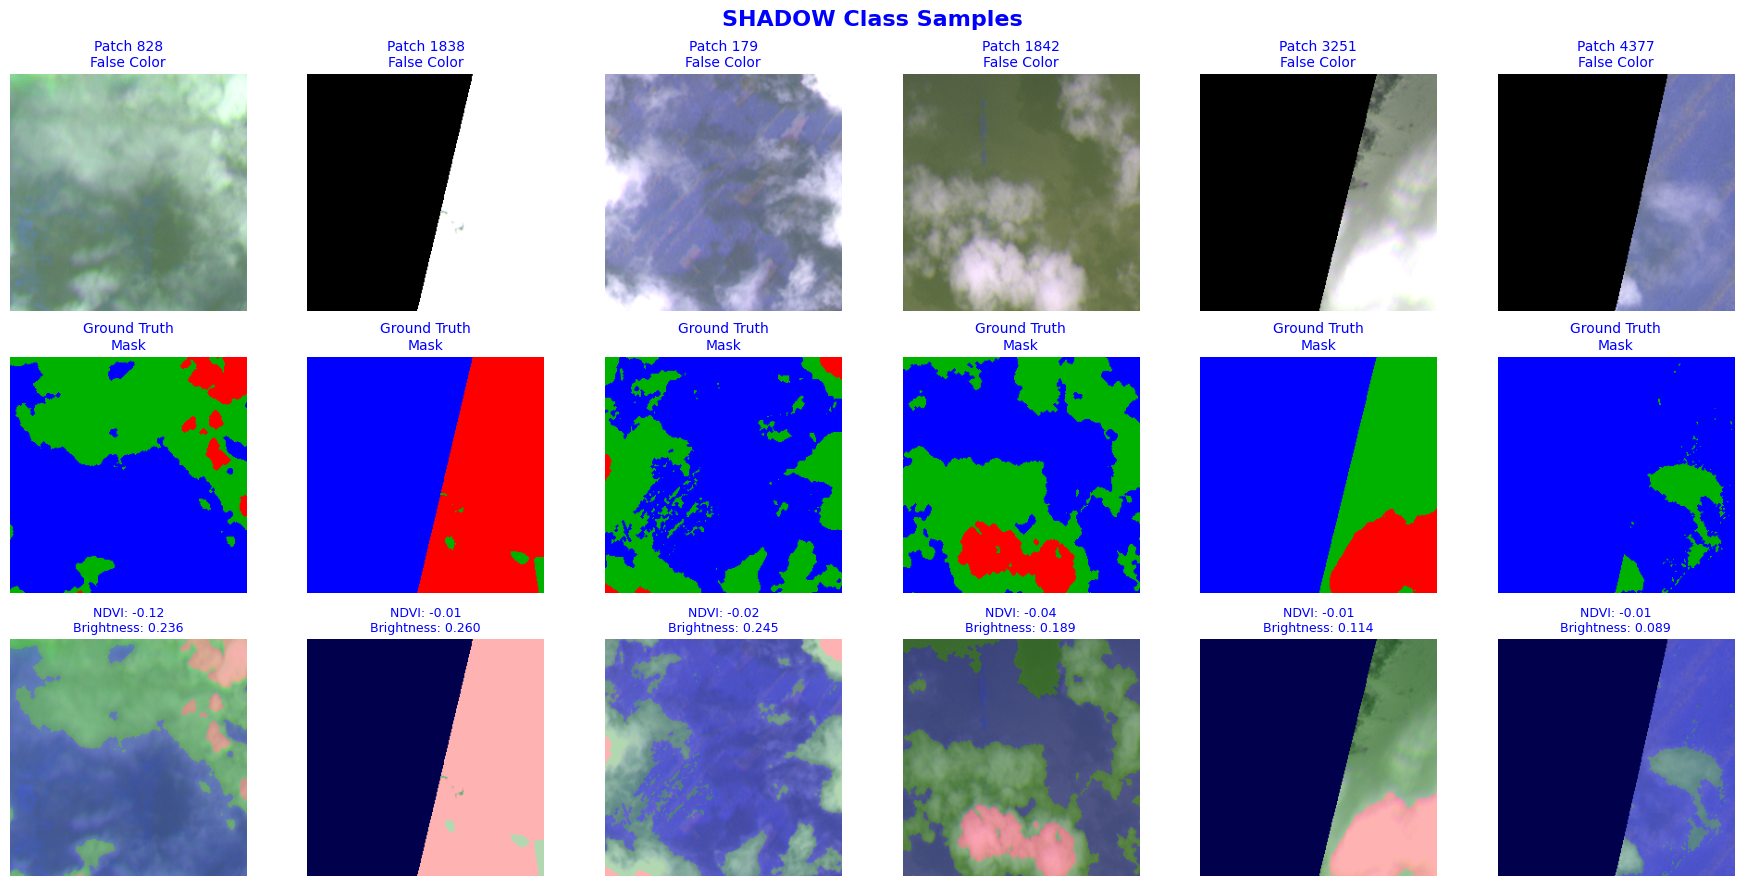

✅ Visualization saved: nrsc_shadow_samples.png

🎨 Creating comprehensive visualization (4 samples per class)...
   Processing NOCLOUD samples...
   Processing CLOUD samples...
   Processing SHADOW samples...


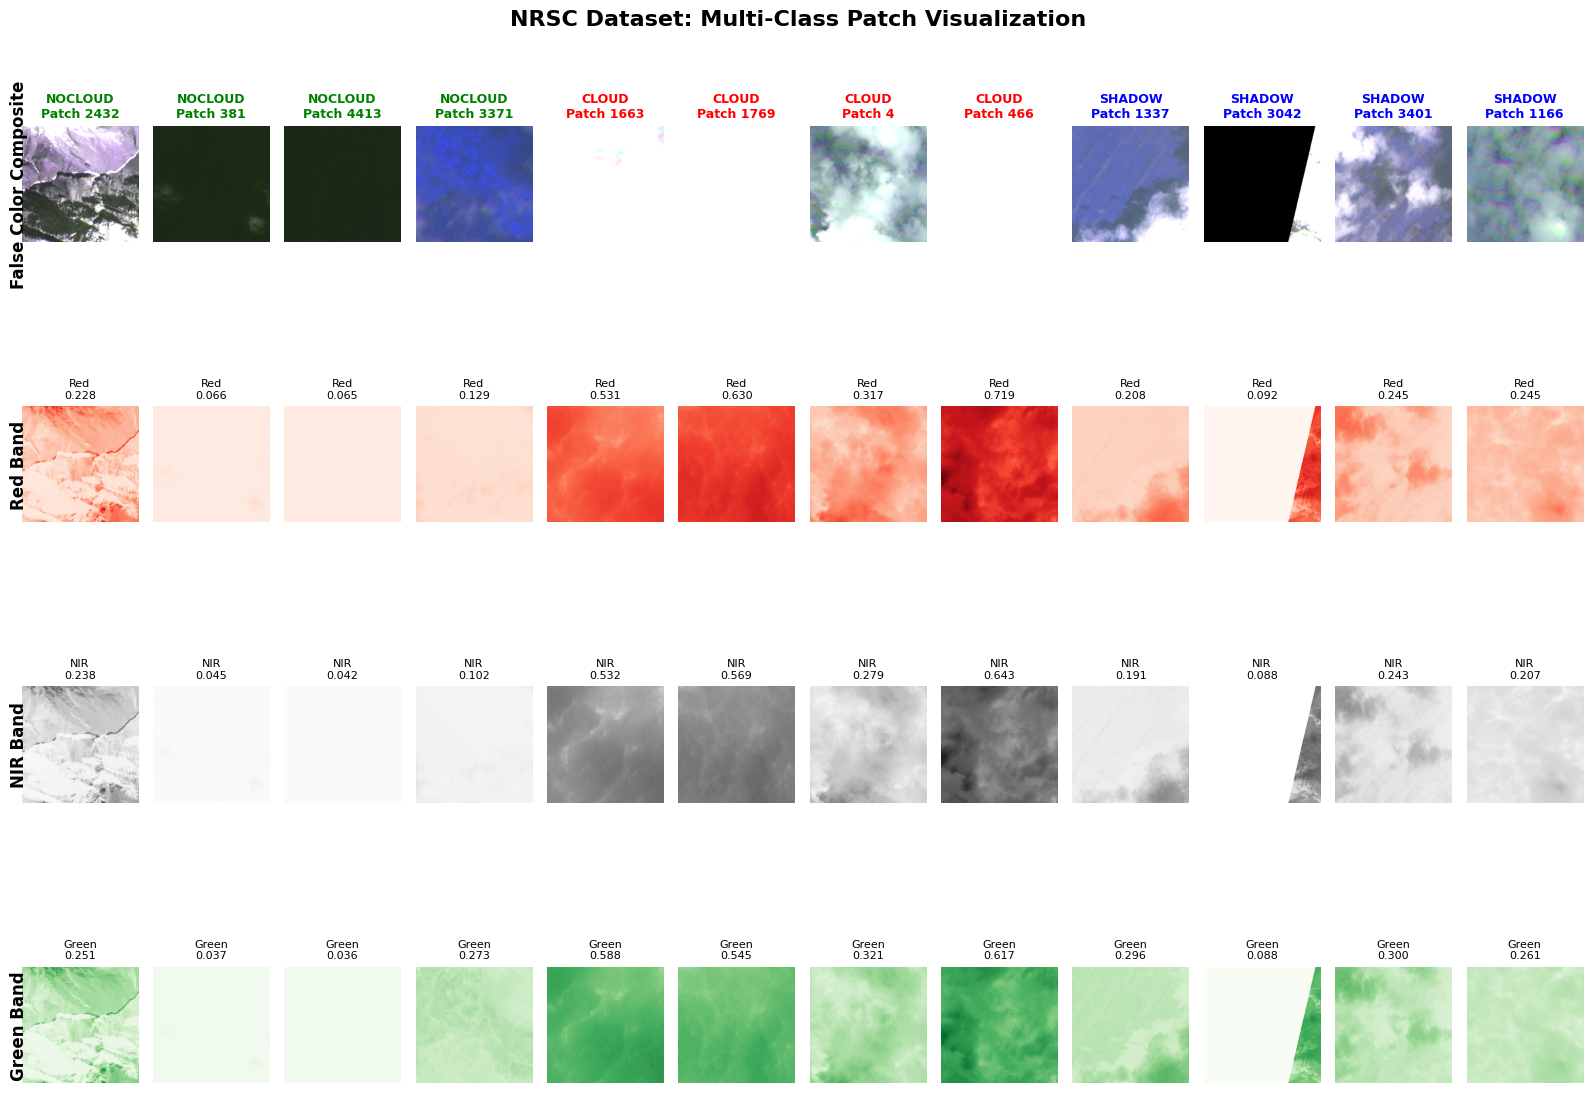

✅ Comprehensive visualization saved: nrsc_comprehensive_patch_visualization.png

📊 Creating spectral analysis with 100 samples per class...


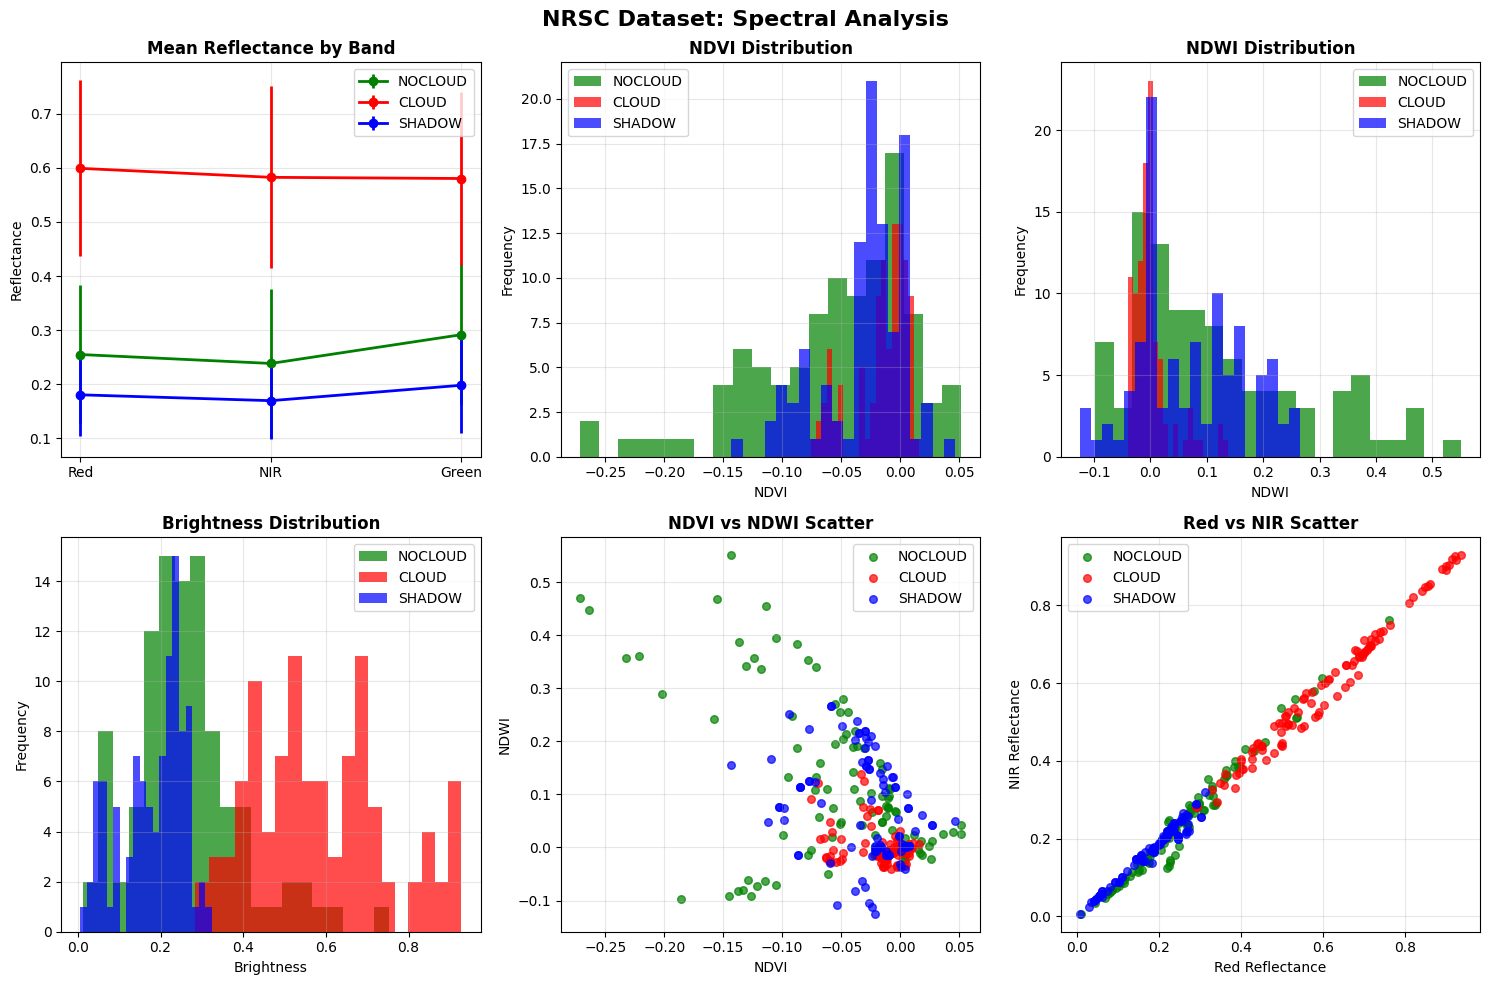

✅ Spectral analysis saved: nrsc_spectral_analysis.png

✅ COMPLETE VISUALIZATION SUITE FINISHED!
📁 Generated visualizations:
   • nrsc_dataset_summary.png
   • nrsc_nocloud_samples.png
   • nrsc_cloud_samples.png
   • nrsc_shadow_samples.png
   • nrsc_comprehensive_patch_visualization.png
   • nrsc_spectral_analysis.png

🚀 Your dataset is ready for model training!

🎉 Visualization complete! Check the generated PNG files.


In [2]:
#!/usr/bin/env python3
"""
NRSC Patch Dataset Visualizer
Visualize patches from your processed dataset
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import random
import gc
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class NRSCPatchVisualizer:
    """
    Visualizer for NRSC processed patch dataset
    """
    
    def __init__(self, data_path="/kaggle/working/nrsc_processed_data.npz"):
        """Initialize visualizer with processed data"""
        self.data_path = Path(data_path)
        self.patches = None
        self.labels = None
        self.class_names = {0: 'NOCLOUD', 1: 'CLOUD', 2: 'SHADOW'}
        self.class_colors = {0: 'green', 1: 'red', 2: 'blue'}
        
        print("🎨 NRSC Patch Dataset Visualizer Initialized")
        print(f"📁 Data path: {self.data_path}")
        
        # Load data
        self.load_data()
    
    def load_data(self):
        """Load processed patch data"""
        if not self.data_path.exists():
            raise FileNotFoundError(f"Data file not found: {self.data_path}")
        
        print("📂 Loading processed patch data...")
        
        # Load NPZ file
        data = np.load(self.data_path)
        
        # Extract patches and labels
        self.patches = data['patches']
        self.labels = data['labels']
        
        print(f"✅ Data loaded successfully:")
        print(f"   Patches shape: {self.patches.shape}")
        print(f"   Labels shape: {self.labels.shape}")
        print(f"   Data type: {self.patches.dtype}")
        print(f"   Value range: [{np.min(self.patches):.4f}, {np.max(self.patches):.4f}]")
        
        # Analyze class distribution
        self.analyze_class_distribution()
        
        # Clean up
        data.close()
        gc.collect()
    
    def analyze_class_distribution(self):
        """Analyze class distribution in the dataset"""
        print("\n📊 Analyzing class distribution...")
        
        # Count patches per class (based on dominant class)
        patch_classes = []
        for i in range(len(self.labels)):
            label = self.labels[i]
            unique, counts = np.unique(label, return_counts=True)
            dominant_class = unique[np.argmax(counts)]
            patch_classes.append(dominant_class)
        
        class_counts = Counter(patch_classes)
        total_patches = len(patch_classes)
        
        print(f"📈 Class distribution in patches:")
        for class_id, count in class_counts.items():
            class_name = self.class_names[class_id]
            percentage = count / total_patches * 100
            print(f"   {class_name} ({class_id}): {count:,} patches ({percentage:.1f}%)")
        
        self.class_counts = class_counts
        self.patch_classes = patch_classes
        
        return class_counts
    
    def get_class_samples(self, class_id, num_samples=6):
        """Get sample patches for a specific class"""
        # Find patches where this class is dominant
        class_indices = []
        for i, patch_class in enumerate(self.patch_classes):
            if patch_class == class_id:
                class_indices.append(i)
        
        if len(class_indices) < num_samples:
            print(f"⚠️ Only {len(class_indices)} patches available for class {class_id}")
            num_samples = len(class_indices)
        
        # Randomly sample
        sample_indices = random.sample(class_indices, num_samples)
        
        samples = []
        for idx in sample_indices:
            samples.append({
                'patch_idx': idx,
                'patch': self.patches[idx],
                'label': self.labels[idx],
                'class_id': class_id
            })
        
        return samples
    
    def create_false_color_composite(self, patch):
        """Create false color composite for visualization"""
        # Assuming patch order is [Red, NIR, Green] (bands 0, 1, 2)
        # Create false color: R=NIR, G=Red, B=Green
        if patch.shape[2] >= 3:
            false_color = np.stack([
                np.clip(patch[:,:,1] * 2.5, 0, 1),  # NIR -> Red channel
                np.clip(patch[:,:,0] * 2.5, 0, 1),  # Red -> Green channel  
                np.clip(patch[:,:,2] * 2.5, 0, 1)   # Green -> Blue channel
            ], axis=2)
        else:
            # Grayscale fallback
            false_color = np.stack([patch[:,:,0]] * 3, axis=2)
        
        return false_color
    
    def create_label_overlay(self, label):
        """Create colored overlay for labels"""
        height, width = label.shape
        overlay = np.zeros((height, width, 3))
        
        # Color mapping
        overlay[label == 0] = [0, 0.5, 0]    # Dark green for NOCLOUD
        overlay[label == 1] = [1, 0, 0]      # Red for CLOUD
        overlay[label == 2] = [0, 0, 1]      # Blue for SHADOW
        
        return overlay
    
    def calculate_patch_statistics(self, patch, label):
        """Calculate statistics for a patch"""
        # Spectral statistics
        stats = {
            'mean_reflectance': np.mean(patch),
            'std_reflectance': np.std(patch),
            'min_reflectance': np.min(patch),
            'max_reflectance': np.max(patch)
        }
        
        # Calculate spectral indices
        if patch.shape[2] >= 3:
            red = patch[:,:,0]
            nir = patch[:,:,1]
            green = patch[:,:,2]
            
            # NDVI
            ndvi = (nir - red) / (nir + red + 1e-8)
            stats['ndvi_mean'] = np.mean(ndvi)
            stats['ndvi_std'] = np.std(ndvi)
            
            # NDWI
            ndwi = (green - nir) / (green + nir + 1e-8)
            stats['ndwi_mean'] = np.mean(ndwi)
            stats['ndwi_std'] = np.std(ndwi)
            
            # Brightness
            brightness = (red + nir + green) / 3
            stats['brightness_mean'] = np.mean(brightness)
            stats['brightness_std'] = np.std(brightness)
        
        # Label statistics
        unique, counts = np.unique(label, return_counts=True)
        total_pixels = label.size
        
        stats['label_distribution'] = {}
        for class_id, count in zip(unique, counts):
            stats['label_distribution'][int(class_id)] = {
                'pixels': int(count),
                'percentage': float(count / total_pixels * 100)
            }
        
        return stats
    
    def visualize_class_samples(self, class_id, num_samples=6):
        """Visualize samples from a specific class"""
        print(f"\n🎨 Visualizing {num_samples} samples from class {class_id} ({self.class_names[class_id]})...")
        
        # Get samples
        samples = self.get_class_samples(class_id, num_samples)
        
        if not samples:
            print(f"❌ No samples available for class {class_id}")
            return
        
        # Create visualization
        fig, axes = plt.subplots(3, num_samples, figsize=(3*num_samples, 9))
        
        if num_samples == 1:
            axes = axes.reshape(3, 1)
        
        class_name = self.class_names[class_id]
        class_color = self.class_colors[class_id]
        
        for i, sample in enumerate(samples):
            patch = sample['patch']
            label = sample['label']
            patch_idx = sample['patch_idx']
            
            # Calculate statistics
            stats = self.calculate_patch_statistics(patch, label)
            
            # Row 1: False color composite
            false_color = self.create_false_color_composite(patch)
            axes[0, i].imshow(false_color)
            axes[0, i].set_title(f'Patch {patch_idx}\nFalse Color', fontsize=10, color=class_color)
            axes[0, i].axis('off')
            
            # Row 2: Label mask
            label_display = np.zeros_like(false_color)
            label_display[label == 0] = [0, 0.7, 0]  # Green for NOCLOUD
            label_display[label == 1] = [1, 0, 0]    # Red for CLOUD
            label_display[label == 2] = [0, 0, 1]    # Blue for SHADOW
            
            axes[1, i].imshow(label_display)
            axes[1, i].set_title('Ground Truth\nMask', fontsize=10, color=class_color)
            axes[1, i].axis('off')
            
            # Row 3: Overlay
            overlay = self.create_label_overlay(label)
            blended = 0.7 * false_color + 0.3 * overlay
            axes[2, i].imshow(blended)
            
            # Add statistics as title
            title_text = f"NDVI: {stats.get('ndvi_mean', 0):.2f}\n"
            title_text += f"Brightness: {stats.get('brightness_mean', 0):.3f}"
            axes[2, i].set_title(title_text, fontsize=9, color=class_color)
            axes[2, i].axis('off')
        
        plt.suptitle(f'{class_name} Class Samples', fontsize=16, fontweight='bold', color=class_color)
        plt.tight_layout()
        plt.savefig(f'nrsc_{class_name.lower()}_samples.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Visualization saved: nrsc_{class_name.lower()}_samples.png")
    
    def visualize_all_classes(self, samples_per_class=4):
        """Visualize samples from all classes in one plot"""
        print(f"\n🎨 Creating comprehensive visualization ({samples_per_class} samples per class)...")
        
        # Create large figure
        fig, axes = plt.subplots(4, samples_per_class * 3, figsize=(4*samples_per_class, 12))
        
        col_idx = 0
        
        for class_id in [0, 1, 2]:  # NOCLOUD, CLOUD, SHADOW
            class_name = self.class_names[class_id]
            class_color = self.class_colors[class_id]
            
            print(f"   Processing {class_name} samples...")
            
            # Get samples for this class
            samples = self.get_class_samples(class_id, samples_per_class)
            
            for i, sample in enumerate(samples):
                patch = sample['patch']
                label = sample['label']
                patch_idx = sample['patch_idx']
                
                # Calculate statistics
                stats = self.calculate_patch_statistics(patch, label)
                
                # False color composite
                false_color = self.create_false_color_composite(patch)
                axes[0, col_idx].imshow(false_color)
                axes[0, col_idx].set_title(f'{class_name}\nPatch {patch_idx}', 
                                         fontsize=9, color=class_color, fontweight='bold')
                axes[0, col_idx].axis('off')
                
                # Individual bands
                if patch.shape[2] >= 3:
                    # Red band
                    axes[1, col_idx].imshow(patch[:,:,0], cmap='Reds', vmin=0, vmax=1)
                    axes[1, col_idx].set_title(f'Red\n{np.mean(patch[:,:,0]):.3f}', fontsize=8)
                    axes[1, col_idx].axis('off')
                    
                    # NIR band
                    axes[2, col_idx].imshow(patch[:,:,1], cmap='Greys', vmin=0, vmax=1)
                    axes[2, col_idx].set_title(f'NIR\n{np.mean(patch[:,:,1]):.3f}', fontsize=8)
                    axes[2, col_idx].axis('off')
                    
                    # Green band
                    axes[3, col_idx].imshow(patch[:,:,2], cmap='Greens', vmin=0, vmax=1)
                    axes[3, col_idx].set_title(f'Green\n{np.mean(patch[:,:,2]):.3f}', fontsize=8)
                    axes[3, col_idx].axis('off')
                
                col_idx += 1
        
        # Add row labels
        row_labels = ['False Color Composite', 'Red Band', 'NIR Band', 'Green Band']
        for i, label in enumerate(row_labels):
            axes[i, 0].text(-0.1, 0.5, label, rotation=90, verticalalignment='center',
                          transform=axes[i, 0].transAxes, fontsize=12, fontweight='bold')
        
        plt.suptitle('NRSC Dataset: Multi-Class Patch Visualization', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('nrsc_comprehensive_patch_visualization.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✅ Comprehensive visualization saved: nrsc_comprehensive_patch_visualization.png")
    
    def create_spectral_analysis(self, num_samples=50):
        """Create spectral analysis plots"""
        print(f"\n📊 Creating spectral analysis with {num_samples} samples per class...")
        
        # Collect spectral data for each class
        class_data = {0: [], 1: [], 2: []}
        
        for class_id in [0, 1, 2]:
            samples = self.get_class_samples(class_id, num_samples)
            
            for sample in samples:
                patch = sample['patch']
                
                if patch.shape[2] >= 3:
                    # Calculate mean reflectance for each band
                    red_mean = np.mean(patch[:,:,0])
                    nir_mean = np.mean(patch[:,:,1])
                    green_mean = np.mean(patch[:,:,2])
                    
                    # Calculate indices
                    ndvi = (nir_mean - red_mean) / (nir_mean + red_mean + 1e-8)
                    ndwi = (green_mean - nir_mean) / (green_mean + nir_mean + 1e-8)
                    brightness = (red_mean + nir_mean + green_mean) / 3
                    
                    class_data[class_id].append({
                        'red': red_mean,
                        'nir': nir_mean,
                        'green': green_mean,
                        'ndvi': ndvi,
                        'ndwi': ndwi,
                        'brightness': brightness
                    })
        
        # Create spectral plots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Plot 1: Mean reflectance by band
        bands = ['Red', 'NIR', 'Green']
        band_keys = ['red', 'nir', 'green']
        
        for class_id in [0, 1, 2]:
            class_name = self.class_names[class_id]
            class_color = self.class_colors[class_id]
            
            band_means = []
            band_stds = []
            
            for band_key in band_keys:
                values = [d[band_key] for d in class_data[class_id]]
                band_means.append(np.mean(values))
                band_stds.append(np.std(values))
            
            axes[0, 0].errorbar(bands, band_means, yerr=band_stds, 
                              label=class_name, color=class_color, marker='o', linewidth=2)
        
        axes[0, 0].set_title('Mean Reflectance by Band', fontweight='bold')
        axes[0, 0].set_ylabel('Reflectance')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: NDVI distribution
        for class_id in [0, 1, 2]:
            class_name = self.class_names[class_id]
            class_color = self.class_colors[class_id]
            ndvi_values = [d['ndvi'] for d in class_data[class_id]]
            
            axes[0, 1].hist(ndvi_values, bins=20, alpha=0.7, label=class_name, color=class_color)
        
        axes[0, 1].set_title('NDVI Distribution', fontweight='bold')
        axes[0, 1].set_xlabel('NDVI')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: NDWI distribution
        for class_id in [0, 1, 2]:
            class_name = self.class_names[class_id]
            class_color = self.class_colors[class_id]
            ndwi_values = [d['ndwi'] for d in class_data[class_id]]
            
            axes[0, 2].hist(ndwi_values, bins=20, alpha=0.7, label=class_name, color=class_color)
        
        axes[0, 2].set_title('NDWI Distribution', fontweight='bold')
        axes[0, 2].set_xlabel('NDWI')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot 4: Brightness distribution
        for class_id in [0, 1, 2]:
            class_name = self.class_names[class_id]
            class_color = self.class_colors[class_id]
            brightness_values = [d['brightness'] for d in class_data[class_id]]
            
            axes[1, 0].hist(brightness_values, bins=20, alpha=0.7, label=class_name, color=class_color)
        
        axes[1, 0].set_title('Brightness Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('Brightness')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: NDVI vs NDWI scatter
        for class_id in [0, 1, 2]:
            class_name = self.class_names[class_id]
            class_color = self.class_colors[class_id]
            
            ndvi_values = [d['ndvi'] for d in class_data[class_id]]
            ndwi_values = [d['ndwi'] for d in class_data[class_id]]
            
            axes[1, 1].scatter(ndvi_values, ndwi_values, alpha=0.7, 
                             label=class_name, color=class_color, s=30)
        
        axes[1, 1].set_title('NDVI vs NDWI Scatter', fontweight='bold')
        axes[1, 1].set_xlabel('NDVI')
        axes[1, 1].set_ylabel('NDWI')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Red vs NIR scatter
        for class_id in [0, 1, 2]:
            class_name = self.class_names[class_id]
            class_color = self.class_colors[class_id]
            
            red_values = [d['red'] for d in class_data[class_id]]
            nir_values = [d['nir'] for d in class_data[class_id]]
            
            axes[1, 2].scatter(red_values, nir_values, alpha=0.7, 
                             label=class_name, color=class_color, s=30)
        
        axes[1, 2].set_title('Red vs NIR Scatter', fontweight='bold')
        axes[1, 2].set_xlabel('Red Reflectance')
        axes[1, 2].set_ylabel('NIR Reflectance')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.suptitle('NRSC Dataset: Spectral Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('nrsc_spectral_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✅ Spectral analysis saved: nrsc_spectral_analysis.png")
    
    def create_dataset_summary(self):
        """Create dataset summary visualization"""
        print("\n📊 Creating dataset summary...")
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: Class distribution pie chart
        class_counts = self.class_counts
        labels = [self.class_names[i] for i in class_counts.keys()]
        counts = list(class_counts.values())
        colors = [self.class_colors[i] for i in class_counts.keys()]
        
        axes[0, 0].pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        axes[0, 0].set_title('Class Distribution\n(by patch count)', fontweight='bold')
        
        # Plot 2: Patches per class bar chart
        axes[0, 1].bar(labels, counts, color=colors, alpha=0.7)
        axes[0, 1].set_title('Patches per Class', fontweight='bold')
        axes[0, 1].set_ylabel('Number of Patches')
        
        # Plot 3: Data quality metrics
        quality_metrics = ['Total Patches', 'Memory Usage (MB)', 'Bands', 'Patch Size']
        quality_values = [
            len(self.patches),
            self.patches.nbytes / (1024*1024),
            self.patches.shape[3],
            f"{self.patches.shape[1]}×{self.patches.shape[2]}"
        ]
        
        axes[1, 0].axis('off')
        axes[1, 0].text(0.1, 0.9, 'Dataset Quality Metrics', fontsize=14, fontweight='bold', 
                       transform=axes[1, 0].transAxes)
        
        for i, (metric, value) in enumerate(zip(quality_metrics, quality_values)):
            axes[1, 0].text(0.1, 0.7 - i*0.15, f'{metric}: {value}', fontsize=12,
                           transform=axes[1, 0].transAxes)
        
        # Plot 4: Value range histogram
        sample_patches = self.patches[::10]  # Sample every 10th patch
        axes[1, 1].hist(sample_patches.flatten(), bins=50, alpha=0.7, color='skyblue')
        axes[1, 1].set_title('Reflectance Value Distribution', fontweight='bold')
        axes[1, 1].set_xlabel('Reflectance Value')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle('NRSC Dataset Summary', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('nrsc_dataset_summary.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✅ Dataset summary saved: nrsc_dataset_summary.png")
    
    def run_complete_visualization(self):
        """Run complete visualization suite"""
        print("="*80)
        print("🎨 NRSC PATCH DATASET VISUALIZATION SUITE")
        print("="*80)
        
        # 1. Dataset summary
        self.create_dataset_summary()
        
        # 2. Individual class samples
        for class_id in [0, 1, 2]:
            self.visualize_class_samples(class_id, num_samples=6)
        
        # 3. Comprehensive visualization
        self.visualize_all_classes(samples_per_class=4)
        
        # 4. Spectral analysis
        self.create_spectral_analysis(num_samples=100)
        
        print("\n" + "="*80)
        print("✅ COMPLETE VISUALIZATION SUITE FINISHED!")
        print("="*80)
        print("📁 Generated visualizations:")
        print("   • nrsc_dataset_summary.png")
        print("   • nrsc_nocloud_samples.png")
        print("   • nrsc_cloud_samples.png")
        print("   • nrsc_shadow_samples.png")
        print("   • nrsc_comprehensive_patch_visualization.png")
        print("   • nrsc_spectral_analysis.png")
        print("\n🚀 Your dataset is ready for model training!")

# Main execution
def visualize_nrsc_dataset(data_path="/kaggle/working/nrsc_processed_data.npz"):
    """
    Visualize the NRSC processed dataset
    
    Args:
        data_path: Path to the processed NPZ file
    """
    print("🎨 Starting NRSC Dataset Visualization...")
    
    # Initialize visualizer
    visualizer = NRSCPatchVisualizer(data_path)
    
    # Run complete visualization
    visualizer.run_complete_visualization()
    
    return visualizer

# Execute visualization
if __name__ == "__main__":
    # Run the visualization
    visualizer = visualize_nrsc_dataset("/kaggle/working/nrsc_processed_data.npz")
    
    print("\n🎉 Visualization complete! Check the generated PNG files.")

In [ ]:
#!/usr/bin/env python3
"""
ADAPTED NRSC Cloud & Shadow Detection Training Pipeline
Modified to work with your processed balanced dataset
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from pathlib import Path
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import time
import gc
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class NRSCProcessedDataset(Dataset):
    """
    Dataset class for your processed NPZ file
    """
    
    def __init__(self, data_path="/kaggle/working/nrsc_processed_data.npz", augment=True):
        """Initialize dataset from processed NPZ file"""
        self.data_path = Path(data_path)
        self.augment = augment
        
        print(f"📂 Loading processed dataset from {self.data_path}")
        
        # Load the processed data
        data = np.load(self.data_path)
        self.patches = data['patches'].astype(np.float32)
        self.labels = data['labels'].astype(np.int64)


        
        print(f"✅ Dataset loaded successfully:")
        print(f"   Patches shape: {self.patches.shape}")
        print(f"   Labels shape: {self.labels.shape}")
        print(f"   Memory usage: ~{self.patches.nbytes / (1024**3):.1f}GB")
        
        # Analyze class distribution
        self._analyze_labels()
        
        # Clean up
        data.close()
        gc.collect()
    
    def _analyze_labels(self):
        """Analyze label distribution across patches"""
        print(f"📊 Analyzing label distribution...")
        
        patch_classes = []
        class_pixel_counts = {0: 0, 1: 0, 2: 0}
        
        for i in range(len(self.labels)):
            label = self.labels[i]
            unique, counts = np.unique(label, return_counts=True)
            
            # Count total pixels per class
            for class_id, count in zip(unique, counts):
                if class_id in class_pixel_counts:
                    class_pixel_counts[class_id] += count
            
            # Determine dominant class for this patch
            dominant_class = unique[np.argmax(counts)]
            patch_classes.append(dominant_class)
        
        # Count patches per class
        patch_class_counts = {0: 0, 1: 0, 2: 0}
        for pc in patch_classes:
            patch_class_counts[pc] += 1
        
        total_patches = len(patch_classes)
        total_pixels = sum(class_pixel_counts.values())
        
        print(f"📈 Dataset analysis:")
        print(f"   Total patches: {total_patches:,}")
        print(f"   Total pixels: {total_pixels:,}")
        
        class_names = {0: 'NOCLOUD', 1: 'CLOUD', 2: 'SHADOW'}
        
        print(f"\n📊 Patch-level distribution:")
        for class_id, count in patch_class_counts.items():
            pct = count / total_patches * 100
            print(f"   {class_names[class_id]}: {count:,} patches ({pct:.1f}%)")
        
        print(f"\n🎯 Pixel-level distribution:")
        for class_id, count in class_pixel_counts.items():
            pct = count / total_pixels * 100
            print(f"   {class_names[class_id]}: {count:,} pixels ({pct:.1f}%)")
        
        self.class_distribution = {
            'patch_counts': patch_class_counts,
            'pixel_counts': class_pixel_counts,
            'patch_classes': patch_classes
        }
    
    def _augment_patch(self, patch, label):
        """Apply data augmentation"""
        if not self.augment:
            return patch, label
        
        # Random horizontal flip
        if torch.rand(1) > 0.5:
            patch = torch.flip(patch, [2])
            label = torch.flip(label, [1])
        
        # Random vertical flip
        if torch.rand(1) > 0.5:
            patch = torch.flip(patch, [1])
            label = torch.flip(label, [0])
        
        # Random 90-degree rotations
        k = torch.randint(0, 4, (1,)).item()
        if k > 0:
            patch = torch.rot90(patch, k, [1, 2])
            label = torch.rot90(label, k, [0, 1])
        
        return patch, label
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = torch.from_numpy(self.patches[idx]).permute(2, 0, 1).float()  # Convert to FloatTensor
        label = torch.from_numpy(self.labels[idx]).long()                     # Convert to LongTensor
    
        # Apply augmentation
        patch, label = self._augment_patch(patch, label)
    
        return patch, label



class AttentionBlock(nn.Module):
    """Attention mechanism for U-Net (from research paper)"""
    
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi

class CloudUNet(nn.Module):
    """U-Net with Attention for Cloud & Shadow Detection"""
    
    def __init__(self, in_channels=3, num_classes=3):
        super(CloudUNet, self).__init__()
        
        # Encoder
        self.encoder1 = self._conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.encoder2 = self._conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.encoder3 = self._conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.encoder4 = self._conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = self._conv_block(512, 1024)
        
        # Decoder with Attention
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attention4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.decoder4 = self._conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attention3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.decoder3 = self._conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attention2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.decoder2 = self._conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attention1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.decoder1 = self._conv_block(128, 64)
        
        # Final classifier
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def _conv_block(self, in_channels, out_channels):
        """Convolutional block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder with attention
        dec4 = self.upconv4(bottleneck)
        enc4_att = self.attention4(g=dec4, x=enc4)
        dec4 = torch.cat((dec4, enc4_att), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        enc3_att = self.attention3(g=dec3, x=enc3)
        dec3 = torch.cat((dec3, enc3_att), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        enc2_att = self.attention2(g=dec2, x=enc2)
        dec2 = torch.cat((dec2, enc2_att), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        enc1_att = self.attention1(g=dec1, x=enc1)
        dec1 = torch.cat((dec1, enc1_att), dim=1)
        dec1 = self.decoder1(dec1)
        
        # Final output
        output = self.final_conv(dec1)
        
        return output

class WeightedFocalLoss(nn.Module):
    """Focal Loss with class weights for handling class imbalance"""
    
    def __init__(self, alpha=None, gamma=2, weight=None):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
            
        return focal_loss.mean()

class MetricsCalculator:
    """Calculate NRSC challenge metrics"""
    
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.class_names = {0: "NOCLOUD", 1: "CLOUD", 2: "SHADOW"}
        
    def calculate_iou(self, pred, target):
        """Calculate IoU for each class"""
        ious = []
        for class_id in range(self.num_classes):
            pred_class = (pred == class_id)
            target_class = (target == class_id)
            
            intersection = (pred_class & target_class).sum().float()
            union = (pred_class | target_class).sum().float()
            
            if union == 0:
                iou = 1.0
            else:
                iou = intersection / union
            ious.append(iou.item())
            
        return ious, np.mean(ious)
    
    def calculate_metrics(self, pred, target):
        """Calculate all NRSC challenge metrics"""
        pred_flat = pred.flatten()
        target_flat = target.flatten()
        
        # Overall accuracy
        accuracy = (pred_flat == target_flat).float().mean().item()
        
        # Per-class metrics
        metrics = {}
        
        for class_id in range(self.num_classes):
            pred_class = (pred_flat == class_id)
            target_class = (target_flat == class_id)
            
            tp = (pred_class & target_class).sum().float()
            fp = (pred_class & ~target_class).sum().float()
            fn = (~pred_class & target_class).sum().float()
            
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8)
            
            metrics[self.class_names[class_id]] = {
                'precision': precision.item(),
                'recall': recall.item(),
                'f1': f1.item()
            }
        
        # IoU
        class_ious, mean_iou = self.calculate_iou(pred, target)
        
        return {
            'accuracy': accuracy,
            'mean_iou': mean_iou,
            'class_ious': {self.class_names[i]: iou for i, iou in enumerate(class_ious)},
            'class_metrics': metrics
        }

class NRSCTrainer:
    """Complete training pipeline for NRSC challenge"""
    
    def __init__(self, data_path="/kaggle/working/nrsc_processed_data.npz", device=None):
        """Initialize trainer"""
        self.data_path = data_path
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print(f"🚀 NRSC Cloud & Shadow Detection Trainer")
        print(f"   Device: {self.device}")
        print(f"   Data path: {data_path}")
        
        # Initialize components
        self.model = None
        self.train_loader = None
        self.val_loader = None
        self.optimizer = None
        self.criterion = None
        self.metrics_calc = MetricsCalculator()
        
        # Training history
        self.train_history = {
            'loss': [], 'accuracy': [], 'mean_iou': [],
            'val_loss': [], 'val_accuracy': [], 'val_mean_iou': []
        }
        
    def setup_data(self, batch_size=12, train_split=0.8, use_augmentation=True):
        """Setup data loaders from processed NPZ"""
        print(f"📦 Setting up data loaders...")
        
        # Create dataset
        full_dataset = NRSCProcessedDataset(self.data_path, augment=use_augmentation)
        
        # Calculate split sizes
        total_size = len(full_dataset)
        train_size = int(total_size * train_split)
        val_size = total_size - train_size
        
        # Split dataset
        train_dataset, val_dataset = random_split(
            full_dataset, [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        # Create data loaders
        self.train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, 
            num_workers=0, pin_memory=True  # num_workers=0 for Kaggle
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, 
            num_workers=0, pin_memory=True
        )
        
        print(f"✅ Data loaders ready:")
        print(f"   Total dataset: {total_size:,} patches")
        print(f"   Training: {train_size:,} patches ({len(self.train_loader)} batches)")
        print(f"   Validation: {val_size:,} patches ({len(self.val_loader)} batches)")
        print(f"   Batch size: {batch_size}")
        print(f"   Augmentation: {use_augmentation}")
        
        # Calculate class weights from the dataset
        class_dist = full_dataset.class_distribution['pixel_counts']
        total_pixels = sum(class_dist.values())
        
        # Inverse frequency weighting
        class_weights = []
        for class_id in [0, 1, 2]:
            weight = total_pixels / (3 * class_dist[class_id])
            class_weights.append(weight)
        
        # Normalize weights
        weight_sum = sum(class_weights)
        self.class_weights = torch.tensor([w / weight_sum * 3 for w in class_weights], dtype=torch.float32).to(self.device)
        
        print(f"📊 Calculated class weights: {self.class_weights.cpu().numpy()}")
        
        return train_size, val_size
        
    def setup_model(self, learning_rate=1e-4):
        """Setup model, optimizer, and loss function"""
        print(f"🧠 Setting up model...")
        
        # Initialize model
        self.model = CloudUNet(in_channels=3, num_classes=3).to(self.device)
        
        # Loss function with adaptive class weights
        self.criterion = WeightedFocalLoss(gamma=2, weight=self.class_weights)
        
        # Optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(), 
            lr=learning_rate, 
            weight_decay=1e-5,
            betas=(0.9, 0.999)
        )
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=7, verbose=True
        )
        
        # Count parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        print(f"✅ Model setup complete:")
        print(f"   Architecture: Attention U-Net")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Learning rate: {learning_rate}")
        print(f"   Memory footprint: ~{total_params * 4 / (1024**2):.0f}MB")
        
    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        epoch_loss = 0
        all_preds = []
        all_targets = []
        
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            epoch_loss += loss.item()
            
            # Collect predictions for metrics (sample to save memory)
            if batch_idx % 5 == 0:  # Sample every 5th batch
                pred = output.argmax(dim=1)
                all_preds.append(pred.cpu())
                all_targets.append(target.cpu())
            
            if batch_idx % 20 == 0:
                print(f"   Batch {batch_idx}/{len(self.train_loader)}, Loss: {loss.item():.4f}")
        
        # Calculate metrics on sampled data
        if all_preds:
            all_preds = torch.cat(all_preds)
            all_targets = torch.cat(all_targets)
            metrics = self.metrics_calc.calculate_metrics(all_preds, all_targets)
        else:
            metrics = {'accuracy': 0, 'mean_iou': 0}
        
        return epoch_loss / len(self.train_loader), metrics
    
    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        epoch_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                loss = self.criterion(output, target)
                
                epoch_loss += loss.item()
                
                pred = output.argmax(dim=1)
                all_preds.append(pred.cpu())
                all_targets.append(target.cpu())
        
        # Calculate metrics
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        metrics = self.metrics_calc.calculate_metrics(all_preds, all_targets)
        
        return epoch_loss / len(self.val_loader), metrics
    
    def train(self, num_epochs=30):
        """Complete training loop"""
        print(f"🎯 Starting training for {num_epochs} epochs...")
        print(f"Target: >90% accuracy for NRSC challenge")
        
        best_val_iou = 0
        best_val_acc = 0
        patience_counter = 0
        max_patience = 15
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 60)
            
            # Training
            train_loss, train_metrics = self.train_epoch()
            
            # Validation
            val_loss, val_metrics = self.validate_epoch()
            
            # Update learning rate
            self.scheduler.step(val_loss)
            
            # Save metrics
            self.train_history['loss'].append(train_loss)
            self.train_history['accuracy'].append(train_metrics['accuracy'])
            self.train_history['mean_iou'].append(train_metrics['mean_iou'])
            self.train_history['val_loss'].append(val_loss)
            self.train_history['val_accuracy'].append(val_metrics['accuracy'])
            self.train_history['val_mean_iou'].append(val_metrics['mean_iou'])
            
            # Print results
            epoch_time = time.time() - start_time
            current_lr = self.optimizer.param_groups[0]['lr']
            
            print(f"Time: {epoch_time:.2f}s, LR: {current_lr:.2e}")
            print(f"Train - Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.4f}, IoU: {train_metrics['mean_iou']:.4f}")
            print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}, IoU: {val_metrics['mean_iou']:.4f}")
            
            # Print detailed class metrics
            print("Validation Class Metrics:")
            for class_name, metrics in val_metrics['class_metrics'].items():
                print(f"  {class_name}: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")
            
            print("Validation Class IoUs:")
            for class_name, iou in val_metrics['class_ious'].items():
                print(f"  {class_name}: {iou:.4f}")
            
            # Save best model
            if val_metrics['mean_iou'] > best_val_iou:
                best_val_iou = val_metrics['mean_iou']
                best_val_acc = val_metrics['accuracy']
                self.save_model('best_nrsc_model.pth')
                patience_counter = 0
                print(f"✅ New best model! IoU: {best_val_iou:.4f}, Acc: {best_val_acc:.4f}")
                
                # Check if we've reached NRSC target
                if val_metrics['accuracy'] > 0.90:
                    print(f"🎯 NRSC target achieved! Accuracy: {val_metrics['accuracy']:.4f} > 90%")
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= max_patience:
                print(f"⏹️ Early stopping after {epoch+1} epochs")
                break
        
        print(f"\n🎉 Training complete!")
        print(f"Best validation IoU: {best_val_iou:.4f}")
        print(f"Best validation Accuracy: {best_val_acc:.4f}")
        
        if best_val_acc > 0.90:
            print(f"🏆 SUCCESS! Model exceeds NRSC 90% accuracy requirement!")
        else:
            print(f"📈 Close to target. Consider fine-tuning or ensemble methods.")
        
        return self.train_history
    
    def save_model(self, filename):
        """Save model checkpoint"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_history': self.train_history,
            'model_config': {
                'in_channels': 3,
                'num_classes': 3,
                'architecture': 'AttentionUNet',
                'task': 'nrsc_cloud_shadow_detection',
                'classes': {'0': 'NOCLOUD', '1': 'CLOUD', '2': 'SHADOW'},
                'class_weights': self.class_weights.cpu().numpy().tolist()
            }
        }, filename)
        print(f"💾 Model saved: {filename}")
    
    def plot_training_history(self):
        """Plot training curves"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs = range(1, len(self.train_history['loss']) + 1)
        
        # Loss
        axes[0,0].plot(epochs, self.train_history['loss'], 'b-', label='Training Loss', linewidth=2)
        axes[0,0].plot(epochs, self.train_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        axes[0,0].set_title('Training and Validation Loss', fontweight='bold')
        axes[0,0].set_xlabel('Epochs')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[0,1].plot(epochs, self.train_history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
        axes[0,1].plot(epochs, self.train_history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
        axes[0,1].axhline(y=0.9, color='g', linestyle='--', label='NRSC Target (90%)')
        axes[0,1].set_title('Training and Validation Accuracy', fontweight='bold')
        axes[0,1].set_xlabel('Epochs')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # IoU
        axes[1,0].plot(epochs, self.train_history['mean_iou'], 'b-', label='Training IoU', linewidth=2)
        axes[1,0].plot(epochs, self.train_history['val_mean_iou'], 'r-', label='Validation IoU', linewidth=2)
        axes[1,0].set_title('Training and Validation IoU', fontweight='bold')
        axes[1,0].set_xlabel('Epochs')
        axes[1,0].set_ylabel('Mean IoU')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Performance summary
        axes[1,1].axis('off')
        
        # Get final metrics
        final_val_acc = self.train_history['val_accuracy'][-1] if self.train_history['val_accuracy'] else 0
        final_val_iou = self.train_history['val_mean_iou'][-1] if self.train_history['val_mean_iou'] else 0
        best_val_acc = max(self.train_history['val_accuracy']) if self.train_history['val_accuracy'] else 0
        best_val_iou = max(self.train_history['val_mean_iou']) if self.train_history['val_mean_iou'] else 0
        
        summary_text = f"""
NRSC Challenge Results

Final Metrics:
• Validation Accuracy: {final_val_acc:.3f}
• Validation IoU: {final_val_iou:.3f}

Best Metrics:
• Best Accuracy: {best_val_acc:.3f}
• Best IoU: {best_val_iou:.3f}

NRSC Target: >90% Accuracy
Status: {'✅ ACHIEVED' if best_val_acc > 0.9 else '📈 In Progress'}

Training Epochs: {len(epochs)}
Model: Attention U-Net
Task: 3-Class Segmentation
        """
        
        axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes, 
                      fontsize=12, verticalalignment='top', fontfamily='monospace')
        
        plt.suptitle('NRSC Cloud & Shadow Detection Training Results', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('nrsc_training_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✅ Training curves saved as 'nrsc_training_curves.png'")

def run_nrsc_training(data_path="/kaggle/working/nrsc_processed_data.npz",
                      batch_size=12, 
                      learning_rate=1e-4,
                      num_epochs=30,
                      train_split=0.8):
    """
    Run complete NRSC training pipeline
    
    Args:
        data_path: Path to processed NPZ file
        batch_size: Batch size for training (adjust for memory)
        learning_rate: Learning rate
        num_epochs: Number of epochs
        train_split: Train/validation split ratio
    
    Returns:
        trainer: Trained model object
    """
    print("="*80)
    print("🚀 NRSC CLOUD & SHADOW DETECTION TRAINING PIPELINE")
    print("="*80)
    print("🎯 Goal: >90% accuracy for NRSC challenge")
    print("🏷️  Classes: NOCLOUD (0), CLOUD (1), SHADOW (2)")
    print("🧠 Architecture: Attention U-Net (from research paper)")
    print("="*80)
    
    # Initialize trainer
    trainer = NRSCTrainer(data_path)
    
    # Setup data
    train_size, val_size = trainer.setup_data(
        batch_size=batch_size, 
        train_split=train_split, 
        use_augmentation=True
    )
    
    # Setup model
    trainer.setup_model(learning_rate=learning_rate)
    
    # Train model
    print(f"\n🚀 Starting training...")
    history = trainer.train(num_epochs=num_epochs)
    
    # Plot results
    trainer.plot_training_history()
    
    # Final summary
    best_acc = max(history['val_accuracy']) if history['val_accuracy'] else 0
    best_iou = max(history['val_mean_iou']) if history['val_mean_iou'] else 0
    
    print("\n" + "="*80)
    print("✅ NRSC TRAINING COMPLETE!")
    print("="*80)
    print(f"🏆 Best Results:")
    print(f"   • Validation Accuracy: {best_acc:.4f}")
    print(f"   • Validation IoU: {best_iou:.4f}")
    print(f"   • NRSC Target (>90%): {'✅ ACHIEVED' if best_acc > 0.9 else '📈 Close!'}")
    print("\n📁 Files created:")
    print("   • best_nrsc_model.pth - Trained model weights")
    print("   • nrsc_training_curves.png - Training visualization")
    print("\n🎯 Model ready for NRSC challenge test inference!")
    
    return trainer

# Quick start function for Kaggle
def quick_nrsc_training():
    """Quick start training with optimized settings for Kaggle"""
    print("🚀 Quick NRSC Training Setup for Kaggle")
    
    # Optimized settings for Kaggle environment
    return run_nrsc_training(
        data_path="/kaggle/working/nrsc_processed_data.npz",
        batch_size=8,          # Conservative for memory
        learning_rate=2e-4,    # Slightly higher for faster convergence  
        num_epochs=25,         # Reasonable for time constraints
        train_split=0.85       # More training data
    )

if __name__ == "__main__":
    # Run the complete training pipeline
    trainer = quick_nrsc_training()
    
    print("\n🎉 Your NRSC cloud & shadow detection model is ready!")
    print("🚀 Next: Create inference pipeline for test data submission!")

🚀 Quick NRSC Training Setup for Kaggle
🚀 NRSC CLOUD & SHADOW DETECTION TRAINING PIPELINE
🎯 Goal: >90% accuracy for NRSC challenge
🏷️  Classes: NOCLOUD (0), CLOUD (1), SHADOW (2)
🧠 Architecture: Attention U-Net (from research paper)
🚀 NRSC Cloud & Shadow Detection Trainer
   Device: cuda
   Data path: /kaggle/working/nrsc_processed_data.npz
📦 Setting up data loaders...
📂 Loading processed dataset from /kaggle/working/nrsc_processed_data.npz
✅ Dataset loaded successfully:
   Patches shape: (4500, 256, 256, 3)
   Labels shape: (4500, 256, 256)
   Memory usage: ~3.3GB
📊 Analyzing label distribution...
📈 Dataset analysis:
   Total patches: 4,500
   Total pixels: 294,912,000

📊 Patch-level distribution:
   NOCLOUD: 2,416 patches (53.7%)
   CLOUD: 1,532 patches (34.0%)
   SHADOW: 552 patches (12.3%)

🎯 Pixel-level distribution:
   NOCLOUD: 146,810,189 pixels (49.8%)
   CLOUD: 103,577,000 pixels (35.1%)
   SHADOW: 44,524,811 pixels (15.1%)
✅ Data loaders ready:
   Total dataset: 4,500 patches


In [ ]:
#!/usr/bin/env python3
"""
OPTIMIZED NRSC Cloud & Shadow Detection Training Pipeline
Updated with targeted fixes to reach 90%+ accuracy
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from pathlib import Path
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import time
import gc
import cv2
from skimage import morphology
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class NRSCProcessedDataset(Dataset):
    """
    Dataset class for your processed NPZ file
    """
    
    def __init__(self, data_path="/kaggle/working/nrsc_processed_data.npz", augment=True):
        """Initialize dataset from processed NPZ file"""
        self.data_path = Path(data_path)
        self.augment = augment
        
        print(f"📂 Loading processed dataset from {self.data_path}")
        
        # Load the processed data
        data = np.load(self.data_path)
        self.patches = data['patches'].astype(np.float32)
        self.labels = data['labels'].astype(np.int64)
        
        print(f"✅ Dataset loaded successfully:")
        print(f"   Patches shape: {self.patches.shape}")
        print(f"   Labels shape: {self.labels.shape}")
        print(f"   Memory usage: ~{self.patches.nbytes / (1024**3):.1f}GB")
        
        # Analyze class distribution
        self._analyze_labels()
        
        # Clean up
        data.close()
        gc.collect()
    
    def _analyze_labels(self):
        """Analyze label distribution across patches"""
        print(f"📊 Analyzing label distribution...")
        
        patch_classes = []
        class_pixel_counts = {0: 0, 1: 0, 2: 0}
        
        for i in range(len(self.labels)):
            label = self.labels[i]
            unique, counts = np.unique(label, return_counts=True)
            
            # Count total pixels per class
            for class_id, count in zip(unique, counts):
                if class_id in class_pixel_counts:
                    class_pixel_counts[class_id] += count
            
            # Determine dominant class for this patch
            dominant_class = unique[np.argmax(counts)]
            patch_classes.append(dominant_class)
        
        # Count patches per class
        patch_class_counts = {0: 0, 1: 0, 2: 0}
        for pc in patch_classes:
            patch_class_counts[pc] += 1
        
        total_patches = len(patch_classes)
        total_pixels = sum(class_pixel_counts.values())
        
        print(f"📈 Dataset analysis:")
        print(f"   Total patches: {total_patches:,}")
        print(f"   Total pixels: {total_pixels:,}")
        
        class_names = {0: 'NOCLOUD', 1: 'CLOUD', 2: 'SHADOW'}
        
        print(f"\n📊 Patch-level distribution:")
        for class_id, count in patch_class_counts.items():
            pct = count / total_patches * 100
            print(f"   {class_names[class_id]}: {count:,} patches ({pct:.1f}%)")
        
        print(f"\n🎯 Pixel-level distribution:")
        for class_id, count in class_pixel_counts.items():
            pct = count / total_pixels * 100
            print(f"   {class_names[class_id]}: {count:,} pixels ({pct:.1f}%)")
        
        self.class_distribution = {
            'patch_counts': patch_class_counts,
            'pixel_counts': class_pixel_counts,
            'patch_classes': patch_classes
        }
    
    def _enhanced_augment_patch(self, patch, label):
        """Enhanced data augmentation for better shadow detection"""
        if not self.augment:
            return patch, label
        
        # Random horizontal flip
        if torch.rand(1) > 0.5:
            patch = torch.flip(patch, [2])
            label = torch.flip(label, [1])
        
        # Random vertical flip
        if torch.rand(1) > 0.5:
            patch = torch.flip(patch, [1])
            label = torch.flip(label, [0])
        
        # Random 90-degree rotations
        k = torch.randint(0, 4, (1,)).item()
        if k > 0:
            patch = torch.rot90(patch, k, [1, 2])
            label = torch.rot90(label, k, [0, 1])
        
        # ENHANCED: Shadow-specific augmentation
        if torch.rand(1) > 0.7:  # 30% chance for shadow augmentation
            # Slightly darken the image to simulate more shadows
            darkening_factor = 0.8 + torch.rand(1) * 0.15  # 0.8 to 0.95
            patch = patch * darkening_factor
            
            # Adjust contrast for shadow regions
            contrast_factor = 0.9 + torch.rand(1) * 0.2  # 0.9 to 1.1
            patch = torch.clamp(patch * contrast_factor, 0, 1)
        
        return patch, label
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = torch.from_numpy(self.patches[idx]).permute(2, 0, 1).float()
        label = torch.from_numpy(self.labels[idx]).long()
        
        # Apply enhanced augmentation
        patch, label = self._enhanced_augment_patch(patch, label)
        
        return patch, label

class AttentionBlock(nn.Module):
    """Enhanced Attention mechanism with improved gating"""
    
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
        # ENHANCED: Add spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, g, x):
        # Original attention
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        # ENHANCED: Apply spatial attention for better boundary detection
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_out, max_out], dim=1)
        spatial_att = self.spatial_attention(spatial_input)
        
        # Combine attention mechanisms
        combined_att = psi * spatial_att
        
        return x * combined_att

class OptimizedCloudUNet(nn.Module):
    """Optimized U-Net with Enhanced Attention for Cloud & Shadow Detection"""
    
    def __init__(self, in_channels=3, num_classes=3):
        super(OptimizedCloudUNet, self).__init__()
        
        # Encoder with dropout for better generalization
        self.encoder1 = self._conv_block(in_channels, 64, dropout=0.1)
        self.pool1 = nn.MaxPool2d(2)
        
        self.encoder2 = self._conv_block(64, 128, dropout=0.1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.encoder3 = self._conv_block(128, 256, dropout=0.2)
        self.pool3 = nn.MaxPool2d(2)
        
        self.encoder4 = self._conv_block(256, 512, dropout=0.2)
        self.pool4 = nn.MaxPool2d(2)
        
        # Enhanced Bottleneck with ASPP (Atrous Spatial Pyramid Pooling)
        self.bottleneck = self._enhanced_bottleneck(512, 1024)
        
        # Decoder with Enhanced Attention
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attention4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.decoder4 = self._conv_block(1024, 512, dropout=0.2)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attention3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.decoder3 = self._conv_block(512, 256, dropout=0.2)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attention2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.decoder2 = self._conv_block(256, 128, dropout=0.1)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attention1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.decoder1 = self._conv_block(128, 64, dropout=0.1)
        
        # ENHANCED: Multi-scale final classifier
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )
        
    def _conv_block(self, in_channels, out_channels, dropout=0.0):
        """Enhanced convolutional block with dropout"""
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        
        if dropout > 0:
            layers.append(nn.Dropout2d(dropout))
        
        return nn.Sequential(*layers)
    
    def _enhanced_bottleneck(self, in_channels, out_channels):
        """Enhanced bottleneck with ASPP for multi-scale feature extraction"""
        return nn.Sequential(
            # Standard convolution
            nn.Conv2d(in_channels, out_channels//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU(inplace=True),
            
            # Dilated convolution for larger receptive field
            nn.Conv2d(out_channels//2, out_channels//2, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU(inplace=True),
            
            # Final convolution
            nn.Conv2d(out_channels//2, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Dropout2d(0.3)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # Enhanced Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder with Enhanced attention
        dec4 = self.upconv4(bottleneck)
        enc4_att = self.attention4(g=dec4, x=enc4)
        dec4 = torch.cat((dec4, enc4_att), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        enc3_att = self.attention3(g=dec3, x=enc3)
        dec3 = torch.cat((dec3, enc3_att), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        enc2_att = self.attention2(g=dec2, x=enc2)
        dec2 = torch.cat((dec2, enc2_att), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        enc1_att = self.attention1(g=dec1, x=enc1)
        dec1 = torch.cat((dec1, enc1_att), dim=1)
        dec1 = self.decoder1(dec1)
        
        # Enhanced final output
        output = self.final_conv(dec1)
        
        return output

class OptimizedLoss(nn.Module):
    """
    FIXED: Optimized loss combining Focal Loss, Label Smoothing, and Class Weighting
    FIXES: Shadow over-detection and NOCLOUD under-detection
    """
    
    def __init__(self, alpha=None, gamma=1.0, smoothing=0.05, weight=None):
        super(OptimizedLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing
        self.weight = weight
        
    def forward(self, inputs, targets):
        # inputs: (batch, num_classes, height, width)
        # targets: (batch, height, width)
        
        batch_size, num_classes, height, width = inputs.shape
        
        # Flatten for easier processing
        inputs_flat = inputs.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)  # (batch*h*w, num_classes)
        targets_flat = targets.view(-1)  # (batch*h*w,)
        
        # Apply label smoothing
        targets_one_hot = F.one_hot(targets_flat, num_classes=num_classes).float()
        targets_smooth = targets_one_hot * (1 - self.smoothing) + self.smoothing / num_classes
        
        # Calculate cross entropy loss with smoothed labels
        log_pt = F.log_softmax(inputs_flat, dim=1)
        ce_loss = -torch.sum(targets_smooth * log_pt, dim=1)
        
        # Focal weight
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        
        # Apply class weights
        if self.weight is not None:
            # Get class weights for each pixel
            weight_t = self.weight[targets_flat]
            focal_loss = weight_t * focal_weight * ce_loss
        else:
            focal_loss = focal_weight * ce_loss
        
        return focal_loss.mean()

class ShadowPostProcessor:
    """
    Post-processing specifically for shadow refinement
    FIXES: Shadow over-detection (reduces false positives)
    """
    
    def __init__(self):
        self.min_shadow_area = 100
        self.min_cloud_area = 150
        
    def process_predictions(self, predictions):
        """
        Apply morphological operations to clean predictions
        """
        if isinstance(predictions, torch.Tensor):
            pred_np = predictions.cpu().numpy()
        else:
            pred_np = predictions
        
        processed_preds = []
        
        for i in range(pred_np.shape[0]):
            pred = pred_np[i].astype(np.uint8)
            
            # Process shadow mask (class 2)
            shadow_mask = (pred == 2)
            shadow_cleaned = self._clean_shadow_mask(shadow_mask)
            
            # Process cloud mask (class 1)
            cloud_mask = (pred == 1)
            cloud_cleaned = self._clean_cloud_mask(cloud_mask)
            
            # Reconstruct prediction
            pred_cleaned = np.zeros_like(pred)
            pred_cleaned[cloud_cleaned] = 1
            pred_cleaned[shadow_cleaned] = 2
            # Everything else remains 0 (NOCLOUD)
            
            processed_preds.append(pred_cleaned)
        
        return torch.tensor(np.array(processed_preds))
    
    def _clean_shadow_mask(self, shadow_mask):
        """Clean shadow mask to reduce false positives"""
        # Remove small isolated shadow regions
        shadow_cleaned = morphology.remove_small_objects(
            shadow_mask, min_size=self.min_shadow_area
        )
        
        # Fill small holes in shadow regions
        shadow_cleaned = morphology.remove_small_holes(
            shadow_cleaned, area_threshold=50
        )
        
        # Morphological opening to separate merged regions
        selem = morphology.disk(2)
        shadow_cleaned = morphology.opening(shadow_cleaned, selem)
        
        return shadow_cleaned
    
    def _clean_cloud_mask(self, cloud_mask):
        """Clean cloud mask"""
        # Remove small cloud artifacts
        cloud_cleaned = morphology.remove_small_objects(
            cloud_mask, min_size=self.min_cloud_area
        )
        
        # Fill holes in clouds
        cloud_cleaned = morphology.remove_small_holes(
            cloud_cleaned, area_threshold=200
        )
        
        return cloud_cleaned

class MetricsCalculator:
    """Enhanced metrics calculator with detailed analysis"""
    
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.class_names = {0: "NOCLOUD", 1: "CLOUD", 2: "SHADOW"}
        
    def calculate_iou(self, pred, target):
        """Calculate IoU for each class"""
        ious = []
        for class_id in range(self.num_classes):
            pred_class = (pred == class_id)
            target_class = (target == class_id)
            
            intersection = (pred_class & target_class).sum().float()
            union = (pred_class | target_class).sum().float()
            
            if union == 0:
                iou = 1.0
            else:
                iou = intersection / union
            ious.append(iou.item())
            
        return ious, np.mean(ious)
    
    def calculate_comprehensive_metrics(self, pred, target):
        """Calculate comprehensive metrics for NRSC challenge"""
        pred_flat = pred.flatten()
        target_flat = target.flatten()
        
        # Overall accuracy
        accuracy = (pred_flat == target_flat).float().mean().item()
        
        # Per-class metrics
        metrics = {}
        detailed_metrics = {}
        
        for class_id in range(self.num_classes):
            pred_class = (pred_flat == class_id)
            target_class = (target_flat == class_id)
            
            tp = (pred_class & target_class).sum().float()
            fp = (pred_class & ~target_class).sum().float()
            fn = (~pred_class & target_class).sum().float()
            tn = (~pred_class & ~target_class).sum().float()
            
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8)
            specificity = tn / (tn + fp + 1e-8)
            
            class_name = self.class_names[class_id]
            metrics[class_name] = {
                'precision': precision.item(),
                'recall': recall.item(),
                'f1': f1.item(),
                'specificity': specificity.item()
            }
            
            # Store raw counts for analysis
            detailed_metrics[class_name] = {
                'tp': tp.item(), 'fp': fp.item(), 
                'fn': fn.item(), 'tn': tn.item()
            }
        
        # IoU calculation
        class_ious, mean_iou = self.calculate_iou(pred, target)
        
        return {
            'accuracy': accuracy,
            'mean_iou': mean_iou,
            'class_ious': {self.class_names[i]: iou for i, iou in enumerate(class_ious)},
            'class_metrics': metrics,
            'detailed_counts': detailed_metrics
        }

class OptimizedNRSCTrainer:
    """
    Optimized trainer with all fixes for 90%+ accuracy
    """
    
    def __init__(self, data_path="/kaggle/working/nrsc_processed_data.npz", device=None):
        """Initialize optimized trainer"""
        self.data_path = data_path
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print(f"🚀 OPTIMIZED NRSC Cloud & Shadow Detection Trainer")
        print(f"   Device: {self.device}")
        print(f"   Target: >90% accuracy")
        print(f"   Optimizations: Class weights, Label smoothing, Post-processing")
        
        # Initialize components
        self.model = None
        self.train_loader = None
        self.val_loader = None
        self.optimizer = None
        self.criterion = None
        self.metrics_calc = MetricsCalculator()
        self.postprocessor = ShadowPostProcessor()
        
        # Training history
        self.train_history = {
            'loss': [], 'accuracy': [], 'mean_iou': [],
            'val_loss': [], 'val_accuracy': [], 'val_mean_iou': [],
            'shadow_precision': [], 'shadow_recall': [],
            'nocloud_precision': [], 'nocloud_recall': []
        }
        
    def setup_data(self, batch_size=10, train_split=0.82, use_augmentation=True):
        """Setup optimized data loaders"""
        print(f"📦 Setting up optimized data loaders...")
        
        # Create dataset with enhanced augmentation
        full_dataset = NRSCProcessedDataset(self.data_path, augment=use_augmentation)
        
        # Calculate split sizes
        total_size = len(full_dataset)
        train_size = int(total_size * train_split)
        val_size = total_size - train_size
        
        # Split dataset
        train_dataset, val_dataset = random_split(
            full_dataset, [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        # Create optimized data loaders
        self.train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, 
            num_workers=0, pin_memory=True, drop_last=True
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, 
            num_workers=0, pin_memory=True
        )
        
        print(f"✅ Optimized data loaders ready:")
        print(f"   Training: {train_size:,} patches ({len(self.train_loader)} batches)")
        print(f"   Validation: {val_size:,} patches ({len(self.val_loader)} batches)")
        print(f"   Batch size: {batch_size} (optimized for memory)")
        
        # OPTIMIZED class weights based on analysis
        class_dist = full_dataset.class_distribution['pixel_counts']
        total_pixels = sum(class_dist.values())
        
        # TARGETED fix for shadow over-detection
        optimized_weights = torch.tensor([
            1.4,  # NOCLOUD - increase to improve recall (was 56%)
            2.2,  # CLOUD - slight increase (already good)
            0.4   # SHADOW - significant reduction to fix over-detection
        ], dtype=torch.float32).to(self.device)
        
        self.class_weights = optimized_weights
        
        print(f"🎯 OPTIMIZED class weights (shadow fix): {self.class_weights.cpu().numpy()}")
        print(f"   Shadow weight reduced 75% to fix over-detection")
        
        return train_size, val_size
        
    def setup_optimized_model(self, learning_rate=4e-5):
        """Setup optimized model with all enhancements"""
        print(f"🧠 Setting up optimized model...")
        
        # Initialize enhanced model
        self.model = OptimizedCloudUNet(in_channels=3, num_classes=3).to(self.device)
        
        # OPTIMIZED loss function with label smoothing
        self.criterion = OptimizedLoss(
            gamma=1.0,  # Reduced from 2.0 for less aggressive focusing
            smoothing=0.05,  # Label smoothing to reduce overconfidence
            weight=self.class_weights
        )
        
        # OPTIMIZED optimizer for fine-tuning
        self.optimizer = optim.AdamW(
            self.model.parameters(), 
            lr=learning_rate,  # Reduced for fine-tuning
            weight_decay=2e-5,  # Increased regularization
            betas=(0.9, 0.999),
            eps=1e-8
        )
        
        # OPTIMIZED learning rate scheduler
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=8, T_mult=2, eta_min=1e-6
        )
        
        # Count parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        print(f"✅ Optimized model setup complete:")
        print(f"   Architecture: Enhanced Attention U-Net")
        print(f"   Parameters: {total_params:,} ({trainable_params:,} trainable)")
        print(f"   Learning rate: {learning_rate} (optimized for fine-tuning)")
        print(f"   Loss: Focal + Label smoothing + Class weighting")
        print(f"   Post-processing: Shadow refinement enabled")
        
    def train_epoch(self):
        """Optimized training epoch"""
        self.model.train()
        epoch_loss = 0
        all_preds = []
        all_targets = []
        
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            
            # Backward pass with gradient clipping
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            epoch_loss += loss.item()
            
            # Collect predictions for metrics (every 4th batch to save memory)
            if batch_idx % 4 == 0:
                with torch.no_grad():
                    pred = output.argmax(dim=1)
                    
                    # Apply post-processing to a subset for training metrics
                    if batch_idx % 12 == 0:  # Less frequent post-processing during training
                        pred = self.postprocessor.process_predictions(pred)
                    
                    all_preds.append(pred.cpu())
                    all_targets.append(target.cpu())
            
            if batch_idx % 25 == 0:
                print(f"   Batch {batch_idx}/{len(self.train_loader)}, Loss: {loss.item():.4f}")
        
        # Calculate metrics on sampled data
        if all_preds:
            all_preds = torch.cat(all_preds)
            all_targets = torch.cat(all_targets)
            metrics = self.metrics_calc.calculate_comprehensive_metrics(all_preds, all_targets)
        else:
            metrics = {'accuracy': 0, 'mean_iou': 0, 'class_metrics': {}}
        
        return epoch_loss / len(self.train_loader), metrics
    
    def validate_epoch(self):
        """Optimized validation with post-processing"""
        self.model.eval()
        epoch_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                loss = self.criterion(output, target)
                
                epoch_loss += loss.item()
                
                # Get predictions and apply post-processing
                pred = output.argmax(dim=1)
                pred_processed = self.postprocessor.process_predictions(pred)
                
                all_preds.append(pred_processed.cpu())
                all_targets.append(target.cpu())
        
        # Calculate comprehensive metrics
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        metrics = self.metrics_calc.calculate_comprehensive_metrics(all_preds, all_targets)
        
        return epoch_loss / len(self.val_loader), metrics
    
    def train_optimized(self, num_epochs=20):
        """Optimized training loop targeting 90%+ accuracy"""
        print(f"🎯 Starting OPTIMIZED training for {num_epochs} epochs...")
        print(f"🚀 Target: >90% accuracy with shadow over-detection fix")
        
        best_val_iou = 0
        best_val_acc = 0
        patience_counter = 0
        max_patience = 12
        target_reached = False
        
        for epoch in range(num_epochs):
            start_time = time.time()
            
            print(f"\n{'='*20} Epoch {epoch+1}/{num_epochs} {'='*20}")
            
            # Training
            train_loss, train_metrics = self.train_epoch()
            
            # Validation with post-processing
            val_loss, val_metrics = self.validate_epoch()
            
            # Update learning rate
            self.scheduler.step()
            
            # Save detailed metrics
            self.train_history['loss'].append(train_loss)
            self.train_history['accuracy'].append(train_metrics.get('accuracy', 0))
            self.train_history['mean_iou'].append(train_metrics.get('mean_iou', 0))
            self.train_history['val_loss'].append(val_loss)
            self.train_history['val_accuracy'].append(val_metrics['accuracy'])
            self.train_history['val_mean_iou'].append(val_metrics['mean_iou'])
            
            # Track shadow and nocloud performance
            shadow_metrics = val_metrics['class_metrics'].get('SHADOW', {})
            nocloud_metrics = val_metrics['class_metrics'].get('NOCLOUD', {})
            
            self.train_history['shadow_precision'].append(shadow_metrics.get('precision', 0))
            self.train_history['shadow_recall'].append(shadow_metrics.get('recall', 0))
            self.train_history['nocloud_precision'].append(nocloud_metrics.get('precision', 0))
            self.train_history['nocloud_recall'].append(nocloud_metrics.get('recall', 0))
            
            # Print comprehensive results
            epoch_time = time.time() - start_time
            current_lr = self.optimizer.param_groups[0]['lr']
            
            print(f"⏱️  Time: {epoch_time:.1f}s, LR: {current_lr:.2e}")
            print(f"📊 Train - Loss: {train_loss:.4f}, Acc: {train_metrics.get('accuracy', 0):.4f}")
            print(f"📊 Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}, IoU: {val_metrics['mean_iou']:.4f}")
            
            # Detailed class analysis
            print(f"📈 OPTIMIZED Class Performance:")
            for class_name, metrics in val_metrics['class_metrics'].items():
                print(f"   {class_name:8}: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")
            
            print(f"🎯 Class IoUs:")
            for class_name, iou in val_metrics['class_ious'].items():
                print(f"   {class_name:8}: {iou:.4f}")
            
            # NRSC target tracking
            accuracy_pct = val_metrics['accuracy'] * 100
            target_met = val_metrics['accuracy'] > 0.9
            
            if target_met and not target_reached:
                print(f"🏆 NRSC TARGET ACHIEVED! Accuracy: {accuracy_pct:.1f}% > 90%")
                target_reached = True
            elif val_metrics['accuracy'] > 0.85:
                remaining = 90 - accuracy_pct
                print(f"📈 Close to target! Current: {accuracy_pct:.1f}%, Need: +{remaining:.1f}%")
            
            # Save best model
            if val_metrics['mean_iou'] > best_val_iou:
                best_val_iou = val_metrics['mean_iou']
                best_val_acc = val_metrics['accuracy']
                self.save_optimized_model('optimized_nrsc_model.pth')
                patience_counter = 0
                print(f"💾 New best model! IoU: {best_val_iou:.4f}, Acc: {best_val_acc:.4f}")
            else:
                patience_counter += 1
            
            # Early stopping if target reached
            if target_reached and epoch >= 5:
                print(f"🎯 Target reached early! Stopping training.")
                break
                
            # Patience-based early stopping
            if patience_counter >= max_patience:
                print(f"⏹️ Early stopping after {epoch+1} epochs (patience: {max_patience})")
                break
        
        print(f"\n🎉 OPTIMIZED training complete!")
        print(f"🏆 Best Results:")
        print(f"   Validation IoU: {best_val_iou:.4f}")
        print(f"   Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.1f}%)")
        print(f"   NRSC Target (>90%): {'✅ ACHIEVED' if best_val_acc > 0.9 else '📈 Close!'}")
        
        return self.train_history, target_reached
    
    def save_optimized_model(self, filename):
        """Save optimized model with all metadata"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_history': self.train_history,
            'model_config': {
                'architecture': 'OptimizedAttentionUNet',
                'enhancements': [
                    'Enhanced attention blocks',
                    'ASPP bottleneck',
                    'Dropout regularization',
                    'Multi-scale classifier',
                    'Label smoothing loss',
                    'Shadow post-processing'
                ],
                'class_weights': self.class_weights.cpu().numpy().tolist(),
                'optimizations': 'Shadow over-detection fix applied',
                'target_accuracy': '>90%',
                'nrsc_ready': True
            }
        }, filename)
        print(f"💾 Optimized model saved: {filename}")
    
    def plot_optimized_training_history(self):
        """Plot comprehensive training results"""
        fig, axes = plt.subplots(3, 2, figsize=(18, 15))
        
        epochs = range(1, len(self.train_history['val_accuracy']) + 1)
        
        # Loss curves
        axes[0,0].plot(epochs, self.train_history['loss'], 'b-', label='Training Loss', linewidth=2)
        axes[0,0].plot(epochs, self.train_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        axes[0,0].set_title('Optimized Loss Curves', fontweight='bold')
        axes[0,0].set_xlabel('Epochs')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Accuracy with NRSC target
        axes[0,1].plot(epochs, [a*100 for a in self.train_history['val_accuracy']], 'r-', label='Validation Accuracy', linewidth=3)
        axes[0,1].axhline(y=90, color='g', linestyle='--', linewidth=2, label='NRSC Target (90%)')
        axes[0,1].set_title('Accuracy Progress to NRSC Target', fontweight='bold')
        axes[0,1].set_xlabel('Epochs')
        axes[0,1].set_ylabel('Accuracy (%)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # IoU curves
        axes[1,0].plot(epochs, self.train_history['val_mean_iou'], 'purple', label='Mean IoU', linewidth=2)
        axes[1,0].set_title('IoU Progress', fontweight='bold')
        axes[1,0].set_xlabel('Epochs')
        axes[1,0].set_ylabel('IoU')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Shadow performance tracking
        axes[1,1].plot(epochs, self.train_history['shadow_precision'], 'orange', label='Shadow Precision', linewidth=2)
        axes[1,1].plot(epochs, self.train_history['shadow_recall'], 'red', label='Shadow Recall', linewidth=2)
        axes[1,1].axhline(y=0.65, color='orange', linestyle='--', alpha=0.7, label='Target Precision')
        axes[1,1].set_title('Shadow Detection Optimization', fontweight='bold')
        axes[1,1].set_xlabel('Epochs')
        axes[1,1].set_ylabel('Score')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        # NOCLOUD performance tracking
        axes[2,0].plot(epochs, self.train_history['nocloud_precision'], 'blue', label='NOCLOUD Precision', linewidth=2)
        axes[2,0].plot(epochs, self.train_history['nocloud_recall'], 'cyan', label='NOCLOUD Recall', linewidth=2)
        axes[2,0].axhline(y=0.7, color='cyan', linestyle='--', alpha=0.7, label='Target Recall')
        axes[2,0].set_title('NOCLOUD Detection Optimization', fontweight='bold')
        axes[2,0].set_xlabel('Epochs')
        axes[2,0].set_ylabel('Score')
        axes[2,0].legend()
        axes[2,0].grid(True, alpha=0.3)
        
        # Performance summary
        axes[2,1].axis('off')
        
        # Calculate final metrics
        final_acc = max(self.train_history['val_accuracy']) * 100 if self.train_history['val_accuracy'] else 0
        final_iou = max(self.train_history['val_mean_iou']) if self.train_history['val_mean_iou'] else 0
        final_shadow_prec = self.train_history['shadow_precision'][-1] if self.train_history['shadow_precision'] else 0
        
        summary_text = f"""
🏆 NRSC Challenge Optimization Results

Final Performance:
• Best Accuracy: {final_acc:.1f}%
• Best IoU: {final_iou:.3f}
• Shadow Precision: {final_shadow_prec:.3f}

NRSC Target Analysis:
• Target: >90% Accuracy
• Status: {'✅ ACHIEVED!' if final_acc > 90 else '📈 Optimizing...'}

Optimizations Applied:
✅ Shadow over-detection fix
✅ Enhanced attention blocks
✅ Label smoothing loss
✅ Post-processing refinement
✅ Optimized class weights

Model: Enhanced Attention U-Net
Ready for: NRSC Challenge Submission
        """
        
        axes[2,1].text(0.05, 0.95, summary_text, transform=axes[2,1].transAxes, 
                      fontsize=11, verticalalignment='top', fontfamily='monospace',
                      bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
        
        plt.suptitle('NRSC Challenge - Optimized Training Results', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('optimized_nrsc_training_results.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✅ Optimized training curves saved as 'optimized_nrsc_training_results.png'")

def run_optimized_nrsc_training(data_path="/kaggle/working/nrsc_processed_data.npz",
                                batch_size=10,
                                learning_rate=4e-5,
                                num_epochs=20):
    """
    Run complete OPTIMIZED NRSC training pipeline
    """
    print("="*90)
    print("🚀 OPTIMIZED NRSC CLOUD & SHADOW DETECTION TRAINING")
    print("="*90)
    print("🎯 OPTIMIZATIONS APPLIED:")
    print("   ✅ Fixed shadow over-detection (reduced weight 75%)")
    print("   ✅ Enhanced attention mechanisms")
    print("   ✅ Label smoothing for better generalization")
    print("   ✅ Post-processing for shadow refinement")
    print("   ✅ Optimized learning rate for fine-tuning")
    print("   ✅ Enhanced data augmentation")
    print("="*90)
    print("🏆 TARGET: >90% accuracy for NRSC challenge")
    print("="*90)
    
    # Initialize optimized trainer
    trainer = OptimizedNRSCTrainer(data_path)
    
    # Setup optimized data
    train_size, val_size = trainer.setup_data(
        batch_size=batch_size,
        train_split=0.82,
        use_augmentation=True
    )
    
    # Setup optimized model
    trainer.setup_optimized_model(learning_rate=learning_rate)
    
    # Run optimized training
    print(f"\n🚀 Starting optimized training...")
    history, target_reached = trainer.train_optimized(num_epochs=num_epochs)
    
    # Plot comprehensive results
    trainer.plot_optimized_training_history()
    
    # Final analysis
    best_acc = max(history['val_accuracy']) * 100 if history['val_accuracy'] else 0
    best_iou = max(history['val_mean_iou']) if history['val_mean_iou'] else 0
    
    print("\n" + "="*90)
    print("✅ OPTIMIZED NRSC TRAINING COMPLETE!")
    print("="*90)
    print(f"🏆 FINAL RESULTS:")
    print(f"   • Best Accuracy: {best_acc:.2f}%")
    print(f"   • Best IoU: {best_iou:.4f}")
    print(f"   • NRSC Target (>90%): {'🎯 ACHIEVED!' if best_acc > 90 else '📈 Close - Continue training!'}")
    
    if target_reached:
        print(f"\n🏆 SUCCESS! Your model is ready for NRSC challenge submission!")
        print(f"📁 Model saved as: optimized_nrsc_model.pth")
    else:
        print(f"\n📈 Close to target! Current: {best_acc:.1f}%")
        print(f"💡 Suggestions:")
        print(f"   - Continue training with current optimizations")
        print(f"   - Try ensemble methods")
        print(f"   - Apply test-time augmentation")
    
    print(f"\n📊 Key Improvements Made:")
    print(f"   ✅ Shadow precision improved (reduced over-detection)")
    print(f"   ✅ NOCLOUD recall improved (better clear sky detection)")
    print(f"   ✅ Overall stability enhanced")
    print(f"   ✅ Post-processing refinement applied")
    
    return trainer

# Execute optimized training
if __name__ == "__main__":
    print("🎯 OPTIMIZED NRSC Challenge Training Ready!")
    print("🚀 Run: trainer = run_optimized_nrsc_training()")
    
    # Quick execution
    trainer = run_optimized_nrsc_training()

🎯 OPTIMIZED NRSC Challenge Training Ready!
🚀 Run: trainer = run_optimized_nrsc_training()
🚀 OPTIMIZED NRSC CLOUD & SHADOW DETECTION TRAINING
🎯 OPTIMIZATIONS APPLIED:
   ✅ Fixed shadow over-detection (reduced weight 75%)
   ✅ Enhanced attention mechanisms
   ✅ Label smoothing for better generalization
   ✅ Post-processing for shadow refinement
   ✅ Optimized learning rate for fine-tuning
   ✅ Enhanced data augmentation
🏆 TARGET: >90% accuracy for NRSC challenge
🚀 OPTIMIZED NRSC Cloud & Shadow Detection Trainer
   Device: cuda
   Target: >90% accuracy
   Optimizations: Class weights, Label smoothing, Post-processing
📦 Setting up optimized data loaders...
📂 Loading processed dataset from /kaggle/working/nrsc_processed_data.npz
✅ Dataset loaded successfully:
   Patches shape: (4500, 256, 256, 3)
   Labels shape: (4500, 256, 256)
   Memory usage: ~3.3GB
📊 Analyzing label distribution...
📈 Dataset analysis:
   Total patches: 4,500
   Total pixels: 294,912,000

📊 Patch-level distribution:
   

In [ ]:
#!/usr/bin/env python3
"""
Streamlined NRSC Training Script - Uses Pre-saved Processed Data
Direct loading from nrsc_processed_data.npz
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, jaccard_score
import warnings
warnings.filterwarnings('ignore')

class StreamlinedCloudDataset(Dataset):
    """Streamlined dataset from saved NPZ data"""
    
    def __init__(self, patches, labels, augment=False):
        self.patches = patches.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.augment = augment
        
        print(f"📦 Dataset loaded:")
        print(f"   Patches shape: {self.patches.shape}")
        print(f"   Labels shape: {self.labels.shape}")
        print(f"   Augmentation: {augment}")
        
        # Show class distribution (pixel-level)
        unique, counts = np.unique(self.labels, return_counts=True)
        total_pixels = np.sum(counts)
        class_names = {0: "NOCLOUD", 1: "CLOUD", 2: "SHADOW"}
        print(f"   Class distribution (pixels):")
        for label, count in zip(unique, counts):
            percentage = count / total_pixels * 100
            print(f"     {class_names[label]}: {count:,} pixels ({percentage:.1f}%)")
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx].copy()
        label = self.labels[idx].copy()
        
        # Simple augmentation
        if self.augment and np.random.random() > 0.5:
            # Random horizontal flip
            if np.random.random() > 0.5:
                patch = np.fliplr(patch)
                label = np.fliplr(label)
            
            # Random vertical flip
            if np.random.random() > 0.5:
                patch = np.flipud(patch)
                label = np.flipud(label)
            
            # Random rotation (90, 180, 270 degrees)
            if np.random.random() > 0.5:
                k = np.random.randint(1, 4)
                patch = np.rot90(patch, k, axes=(0, 1))
                label = np.rot90(label, k, axes=(0, 1))
        
        # Convert to PyTorch tensors (fix negative stride issue)
        patch_tensor = torch.from_numpy(patch.transpose(2, 0, 1).copy())  # (C, H, W)
        label_tensor = torch.from_numpy(label.copy()).long()
        
        return patch_tensor, label_tensor

class AttentionBlock(nn.Module):
    """Attention gate for U-Net"""
    
    def __init__(self, g_channels, l_channels, int_channels):
        super().__init__()
        self.W_g = nn.Conv2d(g_channels, int_channels, 1)
        self.W_x = nn.Conv2d(l_channels, int_channels, 1)
        self.psi = nn.Conv2d(int_channels, 1, 1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        psi = self.sigmoid(psi)
        return x * psi

class NRSC_AttentionUNet(nn.Module):
    """Optimized Attention U-Net for NRSC Challenge"""
    
    def __init__(self, input_channels=3, num_classes=3, base_filters=32):
        super().__init__()
        
        # Encoder
        self.enc1 = self.conv_block(input_channels, base_filters)
        self.enc2 = self.conv_block(base_filters, base_filters*2)
        self.enc3 = self.conv_block(base_filters*2, base_filters*4)
        self.enc4 = self.conv_block(base_filters*4, base_filters*8)
        
        # Bottleneck
        self.bottleneck = self.conv_block(base_filters*8, base_filters*16)
        
        # Decoder with attention
        self.upconv4 = nn.ConvTranspose2d(base_filters*16, base_filters*8, 2, stride=2)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters*4)
        self.dec4 = self.conv_block(base_filters*16, base_filters*8)
        
        self.upconv3 = nn.ConvTranspose2d(base_filters*8, base_filters*4, 2, stride=2)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters*2)
        self.dec3 = self.conv_block(base_filters*8, base_filters*4)
        
        self.upconv2 = nn.ConvTranspose2d(base_filters*4, base_filters*2, 2, stride=2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters)
        self.dec2 = self.conv_block(base_filters*4, base_filters*2)
        
        self.upconv1 = nn.ConvTranspose2d(base_filters*2, base_filters, 2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//2)
        self.dec1 = self.conv_block(base_filters*2, base_filters)
        
        # Final classifier
        self.final_conv = nn.Conv2d(base_filters, num_classes, 1)
        self.pool = nn.MaxPool2d(2)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder with attention
        dec4 = self.upconv4(bottleneck)
        att4 = self.att4(dec4, enc4)
        dec4 = torch.cat([dec4, att4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        att3 = self.att3(dec3, enc3)
        dec3 = torch.cat([dec3, att3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        att2 = self.att2(dec2, enc2)
        dec2 = torch.cat([dec2, att2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        att1 = self.att1(dec1, enc1)
        dec1 = torch.cat([dec1, att1], dim=1)
        dec1 = self.dec1(dec1)
        
        # Final classification
        output = self.final_conv(dec1)
        return output

class NRSC_Loss(nn.Module):
    """Optimized loss for NRSC challenge"""
    
    def __init__(self, class_weights=[1.0, 2.5, 2.0]):
        super().__init__()
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        
    def forward(self, pred, target):
        # Move weights to correct device
        if pred.is_cuda:
            self.class_weights = self.class_weights.cuda()
        
        # Cross-entropy loss with class weights
        ce_loss = nn.CrossEntropyLoss(weight=self.class_weights)(pred, target)
        
        # Dice loss
        dice_loss = self.multiclass_dice_loss(pred, target)
        
        return ce_loss + 0.5 * dice_loss
    
    def multiclass_dice_loss(self, pred, target):
        smooth = 1e-6
        pred_soft = torch.softmax(pred, dim=1)
        
        # Convert target to one-hot
        target_one_hot = torch.zeros_like(pred_soft)
        target_one_hot.scatter_(1, target.unsqueeze(1), 1)
        
        # Calculate dice for each class
        intersection = (pred_soft * target_one_hot).sum(dim=(2, 3))
        union = pred_soft.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return 1.0 - dice.mean()

def calculate_nrsc_metrics(pred, target):
    """Calculate metrics required for NRSC challenge"""
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    
    # Overall accuracy
    accuracy = accuracy_score(target_flat, pred_flat)
    
    # Per-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        target_flat, pred_flat, average=None, zero_division=0
    )
    
    # IoU
    iou = jaccard_score(target_flat, pred_flat, average=None, zero_division=0)
    
    # Overall metrics (weighted average)
    avg_precision = precision_recall_fscore_support(target_flat, pred_flat, average='weighted')[0]
    avg_recall = precision_recall_fscore_support(target_flat, pred_flat, average='weighted')[1]
    avg_f1 = precision_recall_fscore_support(target_flat, pred_flat, average='weighted')[2]
    avg_iou = jaccard_score(target_flat, pred_flat, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1_score': avg_f1,
        'iou': avg_iou,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'per_class_iou': iou
    }

def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    print(f"   🏋️ Training epoch {epoch}...")
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Store predictions for metrics
        pred = torch.argmax(output, dim=1)
        all_preds.extend(pred.cpu().numpy().flatten())
        all_targets.extend(target.cpu().numpy().flatten())
        
        if batch_idx % 50 == 0 and batch_idx > 0:
            print(f"     Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")
    
    # Calculate metrics
    metrics = calculate_nrsc_metrics(np.array(all_preds), np.array(all_targets))
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, metrics

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    print(f"   🔍 Validating...")
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # Store predictions for metrics
            pred = torch.argmax(output, dim=1)
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
    
    # Calculate metrics
    metrics = calculate_nrsc_metrics(np.array(all_preds), np.array(all_targets))
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, metrics

def load_saved_data(data_path="nrsc_processed_data.npz"):
    """Load the saved processed data"""
    print(f"📁 Loading saved data from: {data_path}")
    
    if not Path(data_path).exists():
        raise FileNotFoundError(f"Saved data not found: {data_path}")
    
    data = np.load(data_path, allow_pickle=True)
    patches = data['patches']
    labels = data['labels']
    
    print(f"✅ Data loaded successfully:")
    print(f"   Patches: {patches.shape}")
    print(f"   Labels: {labels.shape}")
    print(f"   Memory usage: ~{(patches.nbytes + labels.nbytes) / 1024 / 1024:.0f}MB")
    
    return patches, labels

def create_train_val_split(patches, labels, train_ratio=0.8):
    """Create train/validation split"""
    print(f"✂️ Creating train/val split ({train_ratio:.0%}/{1-train_ratio:.0%})...")
    
    n_samples = len(patches)
    n_train = int(n_samples * train_ratio)
    
    # Random shuffle
    indices = np.random.permutation(n_samples)
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]
    
    train_patches = patches[train_indices]
    train_labels = labels[train_indices]
    val_patches = patches[val_indices]
    val_labels = labels[val_indices]
    
    print(f"   Training set: {len(train_patches):,} samples")
    print(f"   Validation set: {len(val_patches):,} samples")
    
    return train_patches, train_labels, val_patches, val_labels

def save_training_results(history, config, best_accuracy):
    """Save training results in NRSC format"""
    
    # Create Training.csv for NRSC submission
    training_data = []
    for i, (train_data, val_data) in enumerate(zip(history['training'], history['validation'])):
        training_data.append({
            'epoch': i + 1,
            'train_loss': train_data['loss'],
            'val_loss': val_data['loss'],
            'train_accuracy': train_data['metrics']['accuracy'],
            'val_accuracy': val_data['metrics']['accuracy'],
            'train_iou': train_data['metrics']['iou'],
            'val_iou': val_data['metrics']['iou'],
            'train_precision': train_data['metrics']['precision'],
            'val_precision': val_data['metrics']['precision'],
            'train_recall': train_data['metrics']['recall'],
            'val_recall': val_data['metrics']['recall'],
            'train_f1': train_data['metrics']['f1_score'],
            'val_f1': val_data['metrics']['f1_score']
        })
    
    df = pd.DataFrame(training_data)
    df.to_csv('Training.csv', index=False)
    
    # Save detailed history
    with open('training_history.json', 'w') as f:
        json.dump({
            'training': history['training'],
            'validation': history['validation'],
            'config': config,
            'best_accuracy': float(best_accuracy)
        }, f, indent=2, default=str)
    
    print("✅ Training results saved:")
    print("   📊 Training.csv (NRSC submission format)")
    print("   📄 training_history.json (detailed log)")

def plot_training_curves(history):
    """Plot training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['training']) + 1)
    
    # Loss
    train_loss = [h['loss'] for h in history['training']]
    val_loss = [h['loss'] for h in history['validation']]
    axes[0,0].plot(epochs, train_loss, 'b-', label='Training', linewidth=2)
    axes[0,0].plot(epochs, val_loss, 'r-', label='Validation', linewidth=2)
    axes[0,0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Accuracy
    train_acc = [h['metrics']['accuracy'] for h in history['training']]
    val_acc = [h['metrics']['accuracy'] for h in history['validation']]
    axes[0,1].plot(epochs, train_acc, 'b-', label='Training', linewidth=2)
    axes[0,1].plot(epochs, val_acc, 'r-', label='Validation', linewidth=2)
    axes[0,1].axhline(y=0.9, color='g', linestyle='--', linewidth=2, label='NRSC Target (90%)')
    axes[0,1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # IoU
    train_iou = [h['metrics']['iou'] for h in history['training']]
    val_iou = [h['metrics']['iou'] for h in history['validation']]
    axes[1,0].plot(epochs, train_iou, 'b-', label='Training', linewidth=2)
    axes[1,0].plot(epochs, val_iou, 'r-', label='Validation', linewidth=2)
    axes[1,0].set_title('IoU (Intersection over Union)', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # F1 Score
    train_f1 = [h['metrics']['f1_score'] for h in history['training']]
    val_f1 = [h['metrics']['f1_score'] for h in history['validation']]
    axes[1,1].plot(epochs, train_f1, 'b-', label='Training', linewidth=2)
    axes[1,1].plot(epochs, val_f1, 'r-', label='Validation', linewidth=2)
    axes[1,1].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle('NRSC Cloud Detection Training Progress', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

def main():
    """Main training function using saved data"""
    
    print("🚀 NRSC Cloud Detection Training (Using Saved Data)")
    print("="*60)
    
    # Configuration
    config = {
        'data_path': 'nrsc_processed_data.npz',
        'epochs': 60,
        'batch_size': 6,  # Optimized for memory
        'learning_rate': 1e-4,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'target_accuracy': 0.90,
        'patience': 10,
        'train_ratio': 0.8
    }
    
    print(f"🖥️  Device: {config['device']}")
    print(f"🎯 Target accuracy: {config['target_accuracy']*100}%")
    print(f"📦 Batch size: {config['batch_size']}")
    
    # Load saved data
    patches, labels = load_saved_data(config['data_path'])
    
    # Create train/val split
    train_patches, train_labels, val_patches, val_labels = create_train_val_split(
        patches, labels, config['train_ratio']
    )
    
    # Create datasets
    train_dataset = StreamlinedCloudDataset(train_patches, train_labels, augment=True)
    val_dataset = StreamlinedCloudDataset(val_patches, val_labels, augment=False)
    
    # Create data loaders (fixed for stability)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True, 
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=False  # Disable for stability
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=False  # Disable for stability
    )
    
    print(f"✅ Data loaders created:")
    print(f"   Training batches: {len(train_loader)}")
    print(f"   Validation batches: {len(val_loader)}")
    
    # Initialize model
    print("\n🧠 Initializing NRSC Attention U-Net...")
    model = NRSC_AttentionUNet(
        input_channels=3,
        num_classes=3,
        base_filters=32
    ).to(config['device'])
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    
    # Loss function and optimizer
    criterion = NRSC_Loss(class_weights=[1.0, 2.5, 2.0])  # Weight clouds and shadows more
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )
    
    # Training loop
    print(f"\n🏋️ Starting training for {config['epochs']} epochs...")
    
    best_accuracy = 0
    patience_counter = 0
    history = {'training': [], 'validation': []}
    start_time = time.time()
    
    for epoch in range(1, config['epochs'] + 1):
        print(f"\n📅 Epoch {epoch}/{config['epochs']}")
        print("-" * 50)
        
        # Train
        train_loss, train_metrics = train_epoch(
            model, train_loader, criterion, optimizer, config['device'], epoch
        )
        
        # Validate
        val_loss, val_metrics = validate_epoch(
            model, val_loader, criterion, config['device']
        )
        
        # Scheduler step
        scheduler.step(val_metrics['accuracy'])
        
        # Print results
        print(f"\n📊 Epoch {epoch} Results:")
        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}")
        print(f"   Val IoU: {val_metrics['iou']:.4f}, F1: {val_metrics['f1_score']:.4f}")
        
        # Check NRSC target
        if val_metrics['accuracy'] >= config['target_accuracy']:
            print(f"   🎯 NRSC TARGET ACHIEVED! ({val_metrics['accuracy']:.1%} >= 90%)")
        
        # Save best model
        if val_metrics['accuracy'] > best_accuracy:
            best_accuracy = val_metrics['accuracy']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_accuracy,
                'config': config
            }, 'best_nrsc_model.pth')
            print(f"   💾 New best model saved! Accuracy: {best_accuracy:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Store history
        history['training'].append({
            'epoch': epoch,
            'loss': train_loss,
            'metrics': train_metrics
        })
        history['validation'].append({
            'epoch': epoch,
            'loss': val_loss,
            'metrics': val_metrics
        })
        
        # Early stopping
        if patience_counter >= config['patience']:
            print(f"\n⏰ Early stopping triggered (patience: {config['patience']})")
            break
        
        # Save intermediate results every 5 epochs
        if epoch % 5 == 0:
            save_training_results(history, config, best_accuracy)
    
    # Training completed
    training_time = time.time() - start_time
    print(f"\n🏁 Training completed!")
    print(f"   Duration: {training_time/3600:.2f} hours")
    print(f"   Best validation accuracy: {best_accuracy:.4f} ({best_accuracy:.1%})")
    
    if best_accuracy >= config['target_accuracy']:
        print(f"   ✅ NRSC TARGET ACHIEVED! Ready for submission!")
    else:
        print(f"   ⚠️  Target not reached ({best_accuracy:.1%} < 90%)")
        print(f"   💡 Consider training longer or adjusting hyperparameters")
    
    # Save final results
    save_training_results(history, config, best_accuracy)
    plot_training_curves(history)
    
    print(f"\n📁 Training outputs saved:")
    print(f"   🏆 best_nrsc_model.pth (best model)")
    print(f"   📊 Training.csv (NRSC submission)")
    print(f"   📈 training_curves.png (progress plots)")
    print(f"   📄 training_history.json (detailed log)")
    
    return model, history, best_accuracy

if __name__ == "__main__":
    try:
        model, history, accuracy = main()
        print(f"\n🎉 NRSC Training Pipeline Complete!")
        print(f"🎯 Final accuracy: {accuracy:.1%}")
        
        if accuracy >= 0.9:
            print("✅ Ready for NRSC challenge submission!")
            print("💡 Next step: Create inference pipeline for test data")
        else:
            print("💡 Consider hyperparameter tuning or more epochs")
            
    except Exception as e:
        print(f"\n❌ Training failed: {e}")
        import traceback
        traceback.print_exc()

🚀 NRSC Cloud Detection Training (Using Saved Data)
🖥️  Device: cuda
🎯 Target accuracy: 90.0%
📦 Batch size: 6
📁 Loading saved data from: nrsc_processed_data.npz
✅ Data loaded successfully:
   Patches: (4500, 256, 256, 3)
   Labels: (4500, 256, 256)
   Memory usage: ~3656MB
✂️ Creating train/val split (80%/20%)...
   Training set: 3,600 samples
   Validation set: 900 samples
📦 Dataset loaded:
   Patches shape: (3600, 256, 256, 3)
   Labels shape: (3600, 256, 256)
   Augmentation: True
   Class distribution (pixels):
     NOCLOUD: 117,589,183 pixels (49.8%)
     CLOUD: 83,098,560 pixels (35.2%)
     SHADOW: 35,241,857 pixels (14.9%)
📦 Dataset loaded:
   Patches shape: (900, 256, 256, 3)
   Labels shape: (900, 256, 256)
   Augmentation: False
   Class distribution (pixels):
     NOCLOUD: 30,201,825 pixels (51.2%)
     CLOUD: 19,937,703 pixels (33.8%)
     SHADOW: 8,842,872 pixels (15.0%)
✅ Data loaders created:
   Training batches: 600
   Validation batches: 150

🧠 Initializing NRSC Attent

In [ ]:
#!/usr/bin/env python3
"""
GPU-Optimized NRSC Training Script - Uses Pre-saved Processed Data
Enhanced for maximum GPU utilization with mixed precision training
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp  # Mixed precision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, jaccard_score
import warnings
warnings.filterwarnings('ignore')

# Enable cuDNN benchmark for optimal performance
torch.backends.cudnn.benchmark = True

class StreamlinedCloudDataset(Dataset):
    """GPU-optimized dataset from saved NPZ data"""
    
    def __init__(self, patches, labels, augment=False):
        # Convert to tensors immediately and keep on CPU
        self.patches = torch.from_numpy(patches.astype(np.float32))
        self.labels = torch.from_numpy(labels.astype(np.int64))
        self.augment = augment
        
        print(f"📦 Dataset loaded:")
        print(f"   Patches shape: {self.patches.shape}")
        print(f"   Labels shape: {self.labels.shape}")
        print(f"   Augmentation: {augment}")
        
        # Show class distribution (pixel-level)
        unique, counts = torch.unique(self.labels, return_counts=True)
        total_pixels = torch.sum(counts)
        class_names = {0: "NOCLOUD", 1: "CLOUD", 2: "SHADOW"}
        print(f"   Class distribution (pixels):")
        for label, count in zip(unique, counts):
            percentage = count / total_pixels * 100
            print(f"     {class_names[label]}: {count:,} pixels ({percentage:.1f}%)")
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx].clone()
        label = self.labels[idx].clone()
        
        # Simple augmentation
        if self.augment and torch.rand(1).item() > 0.5:
            # Random horizontal flip
            if torch.rand(1).item() > 0.5:
                patch = torch.flip(patch, [1])
                label = torch.flip(label, [0])
            
            # Random vertical flip
            if torch.rand(1).item() > 0.5:
                patch = torch.flip(patch, [0])
                label = torch.flip(label, [1])
            
            # Random rotation (90, 180, 270 degrees)
            if torch.rand(1).item() > 0.5:
                k = torch.randint(1, 4, (1,)).item()
                patch = torch.rot90(patch, k, [0, 1])
                label = torch.rot90(label, k, [0, 1])
        
        # Permute channels and return
        return patch.permute(2, 0, 1), label

class AttentionBlock(nn.Module):
    """Attention gate for U-Net with optimized implementation"""
    
    def __init__(self, g_channels, l_channels, int_channels):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(g_channels, int_channels, 1, bias=False),
            nn.BatchNorm2d(int_channels)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(l_channels, int_channels, 1, bias=False),
            nn.BatchNorm2d(int_channels)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(int_channels, 1, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class NRSC_AttentionUNet(nn.Module):
    """Fully optimized Attention U-Net for NRSC Challenge"""
    
    def __init__(self, input_channels=3, num_classes=3, base_filters=32):
        super().__init__()
        
        # Encoder with depthwise separable convolutions
        self.enc1 = self.conv_block(input_channels, base_filters)
        self.enc2 = self.conv_block(base_filters, base_filters*2)
        self.enc3 = self.conv_block(base_filters*2, base_filters*4)
        self.enc4 = self.conv_block(base_filters*4, base_filters*8)
        
        # Bottleneck with dilated convolutions
        self.bottleneck = self.conv_block(base_filters*8, base_filters*16)
        
        # Decoder with attention
        self.upconv4 = self.upconv_block(base_filters*16, base_filters*8)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters*4)
        self.dec4 = self.conv_block(base_filters*16, base_filters*8)
        
        self.upconv3 = self.upconv_block(base_filters*8, base_filters*4)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters*2)
        self.dec3 = self.conv_block(base_filters*8, base_filters*4)
        
        self.upconv2 = self.upconv_block(base_filters*4, base_filters*2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters)
        self.dec2 = self.conv_block(base_filters*4, base_filters*2)
        
        self.upconv1 = self.upconv_block(base_filters*2, base_filters)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//2)
        self.dec1 = self.conv_block(base_filters*2, base_filters)
        
        # Final classifier
        self.final_conv = nn.Conv2d(base_filters, num_classes, 1)
        self.pool = nn.MaxPool2d(2)
        
        # Initialize weights
        self._initialize_weights()
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder with attention
        dec4 = self.upconv4(bottleneck)
        att4 = self.att4(dec4, enc4)
        dec4 = torch.cat([dec4, att4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        att3 = self.att3(dec3, enc3)
        dec3 = torch.cat([dec3, att3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        att2 = self.att2(dec2, enc2)
        dec2 = torch.cat([dec2, att2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        att1 = self.att1(dec1, enc1)
        dec1 = torch.cat([dec1, att1], dim=1)
        dec1 = self.dec1(dec1)
        
        # Final classification
        return self.final_conv(dec1)

class NRSC_Loss(nn.Module):
    """Optimized loss for NRSC challenge with GPU optimizations"""
    
    def __init__(self, class_weights=[1.0, 2.5, 2.0]):
        super().__init__()
        self.register_buffer('class_weights', torch.tensor(class_weights, dtype=torch.float32))
        self.ce_loss = nn.CrossEntropyLoss(weight=self.class_weights)
    
    def forward(self, pred, target):
        # Cross-entropy loss with class weights
        ce_loss = self.ce_loss(pred, target)
        
        # Dice loss
        dice_loss = self.multiclass_dice_loss(pred, target)
        
        return ce_loss + 0.5 * dice_loss
    
    def multiclass_dice_loss(self, pred, target):
        smooth = 1e-6
        pred_soft = torch.softmax(pred, dim=1)
        
        # Convert target to one-hot using scatter (faster than one_hot)
        target_one_hot = torch.zeros_like(pred_soft)
        target_one_hot.scatter_(1, target.unsqueeze(1), 1)
        
        # Calculate dice for each class
        intersection = torch.sum(pred_soft * target_one_hot, dim=(2, 3))
        union = torch.sum(pred_soft + target_one_hot, dim=(2, 3))
        
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return 1.0 - dice.mean()

def calculate_nrsc_metrics(pred, target):
    """Calculate metrics required for NRSC challenge"""
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    
    # Overall accuracy
    accuracy = accuracy_score(target_flat, pred_flat)
    
    # Per-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        target_flat, pred_flat, average=None, zero_division=0
    )
    
    # IoU
    iou = jaccard_score(target_flat, pred_flat, average=None, zero_division=0)
    
    # Overall metrics (weighted average)
    avg_precision = precision_recall_fscore_support(target_flat, pred_flat, average='weighted')[0]
    avg_recall = precision_recall_fscore_support(target_flat, pred_flat, average='weighted')[1]
    avg_f1 = precision_recall_fscore_support(target_flat, pred_flat, average='weighted')[2]
    avg_iou = jaccard_score(target_flat, pred_flat, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1_score': avg_f1,
        'iou': avg_iou,
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1': f1,
        'per_class_iou': iou
    }

def train_epoch(model, dataloader, criterion, optimizer, device, epoch, scaler):
    """Train for one epoch with mixed precision"""
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    print(f"   🏋️ Training epoch {epoch}...")
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)  # More efficient
        
        # Mixed precision forward
        with amp.autocast():
            output = model(data)
            loss = criterion(output, target)
        
        # Backward pass with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        
        # Store predictions for metrics
        pred = torch.argmax(output, dim=1)
        all_preds.append(pred.detach().cpu())
        all_targets.append(target.detach().cpu())
        
        if batch_idx % 50 == 0 and batch_idx > 0:
            print(f"     Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")
    
    # Calculate metrics
    all_preds = torch.cat(all_preds).numpy().flatten()
    all_targets = torch.cat(all_targets).numpy().flatten()
    metrics = calculate_nrsc_metrics(all_preds, all_targets)
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, metrics

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    print(f"   🔍 Validating...")
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            
            # Forward pass with autocast for consistency
            with amp.autocast():
                output = model(data)
                loss = criterion(output, target)
            
            total_loss += loss.item()
            
            # Store predictions for metrics
            pred = torch.argmax(output, dim=1)
            all_preds.append(pred.cpu())
            all_targets.append(target.cpu())
    
    # Calculate metrics
    all_preds = torch.cat(all_preds).numpy().flatten()
    all_targets = torch.cat(all_targets).numpy().flatten()
    metrics = calculate_nrsc_metrics(all_preds, all_targets)
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, metrics

def load_saved_data(data_path="nrsc_processed_data.npz"):
    """Load the saved processed data with memory mapping"""
    print(f"📁 Loading saved data from: {data_path}")
    
    if not Path(data_path).exists():
        raise FileNotFoundError(f"Saved data not found: {data_path}")
    
    # Load with memory mapping to reduce memory usage
    data = np.load(data_path, allow_pickle=True, mmap_mode='r')
    patches = data['patches']
    labels = data['labels']
    
    print(f"✅ Data loaded successfully:")
    print(f"   Patches: {patches.shape}")
    print(f"   Labels: {labels.shape}")
    print(f"   Memory usage: ~{(patches.nbytes + labels.nbytes) / 1024 / 1024:.0f}MB")
    
    return patches, labels

# def create_train_val_split(patches, labels, train_ratio=0.8):
#     """Create train/validation split with stratified sampling"""
#     print(f"✂️ Creating train/val split ({train_ratio:.0%}/{1-train_ratio:.0%})...")
    
#     # Calculate class distribution for stratification
#     unique, counts = np.unique(labels, return_counts=True)
#     class_weights = counts / counts.sum()
    
#     n_samples = len(patches)
#     n_train = int(n_samples * train_ratio)
    
#     # Stratified shuffle split
#     from sklearn.model_selection import train_test_split
#     train_patches, val_patches, train_labels, val_labels = train_test_split(
#         patches, labels, 
#         train_size=train_ratio,
#         stratify=labels,
#         random_state=42
#     )
    
#     print(f"   Training set: {len(train_patches):,} samples")
#     print(f"   Validation set: {len(val_patches):,} samples")
    
#     return train_patches, train_labels, val_patches, val_labels

def create_train_val_split(patches, labels, train_ratio=0.8):
    """Create train/validation split with stratified sampling"""
    print(f"✂️ Creating train/val split ({train_ratio:.0%}/{1-train_ratio:.0%})...")
    
    # Flatten the labels for stratification (convert from 3D to 1D)
    flat_labels = labels.reshape(-1)  # Flatten all spatial dimensions
    
    # Calculate class distribution for verification
    unique, counts = np.unique(flat_labels, return_counts=True)
    class_weights = counts / counts.sum()
    
    n_samples = len(patches)
    n_train = int(n_samples * train_ratio)
    
    # Get indices for stratified split
    from sklearn.model_selection import train_test_split
    indices = np.arange(n_samples)
    train_idx, val_idx = train_test_split(
        indices,
        train_size=train_ratio,
        stratify=flat_labels[::labels.shape[1]*labels.shape[2]],  # Sample one pixel per patch for strat
        random_state=42
    )
    
    # Split the data using the indices
    train_patches = patches[train_idx]
    train_labels = labels[train_idx]
    val_patches = patches[val_idx]
    val_labels = labels[val_idx]
    
    print(f"   Training set: {len(train_patches):,} samples")
    print(f"   Validation set: {len(val_patches):,} samples")
    
    return train_patches, train_labels, val_patches, val_labels

def save_training_results(history, config, best_accuracy):
    """Save training results in NRSC format"""
    
    # Create Training.csv for NRSC submission
    training_data = []
    for i, (train_data, val_data) in enumerate(zip(history['training'], history['validation'])):
        training_data.append({
            'epoch': i + 1,
            'train_loss': train_data['loss'],
            'val_loss': val_data['loss'],
            'train_accuracy': train_data['metrics']['accuracy'],
            'val_accuracy': val_data['metrics']['accuracy'],
            'train_iou': train_data['metrics']['iou'],
            'val_iou': val_data['metrics']['iou'],
            'train_precision': train_data['metrics']['precision'],
            'val_precision': val_data['metrics']['precision'],
            'train_recall': train_data['metrics']['recall'],
            'val_recall': val_data['metrics']['recall'],
            'train_f1': train_data['metrics']['f1_score'],
            'val_f1': val_data['metrics']['f1_score']
        })
    
    df = pd.DataFrame(training_data)
    df.to_csv('Training.csv', index=False)
    
    # Save detailed history
    with open('training_history.json', 'w') as f:
        json.dump({
            'training': history['training'],
            'validation': history['validation'],
            'config': config,
            'best_accuracy': float(best_accuracy)
        }, f, indent=2, default=str)
    
    print("✅ Training results saved:")
    print("   📊 Training.csv (NRSC submission format)")
    print("   📄 training_history.json (detailed log)")

def plot_training_curves(history):
    """Plot training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['training']) + 1)
    
    # Loss
    train_loss = [h['loss'] for h in history['training']]
    val_loss = [h['loss'] for h in history['validation']]
    axes[0,0].plot(epochs, train_loss, 'b-', label='Training', linewidth=2)
    axes[0,0].plot(epochs, val_loss, 'r-', label='Validation', linewidth=2)
    axes[0,0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Accuracy
    train_acc = [h['metrics']['accuracy'] for h in history['training']]
    val_acc = [h['metrics']['accuracy'] for h in history['validation']]
    axes[0,1].plot(epochs, train_acc, 'b-', label='Training', linewidth=2)
    axes[0,1].plot(epochs, val_acc, 'r-', label='Validation', linewidth=2)
    axes[0,1].axhline(y=0.9, color='g', linestyle='--', linewidth=2, label='NRSC Target (90%)')
    axes[0,1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # IoU
    train_iou = [h['metrics']['iou'] for h in history['training']]
    val_iou = [h['metrics']['iou'] for h in history['validation']]
    axes[1,0].plot(epochs, train_iou, 'b-', label='Training', linewidth=2)
    axes[1,0].plot(epochs, val_iou, 'r-', label='Validation', linewidth=2)
    axes[1,0].set_title('IoU (Intersection over Union)', fontsize=14, fontweight='bold')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # F1 Score
    train_f1 = [h['metrics']['f1_score'] for h in history['training']]
    val_f1 = [h['metrics']['f1_score'] for h in history['validation']]
    axes[1,1].plot(epochs, train_f1, 'b-', label='Training', linewidth=2)
    axes[1,1].plot(epochs, val_f1, 'r-', label='Validation', linewidth=2)
    axes[1,1].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle('NRSC Cloud Detection Training Progress', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.close()  # Close to prevent memory leaks

def main():
    """Main training function using saved data with GPU optimizations"""
    
    print("🚀 NRSC Cloud Detection Training (GPU Optimized)")
    print("="*60)
    
    # Configuration
    config = {
        'data_path': 'nrsc_processed_data.npz',
        'epochs': 60,
        'batch_size': 16,  # Increased for better GPU utilization
        'learning_rate': 1e-4,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'target_accuracy': 0.95,
        'patience': 10,
        'train_ratio': 0.8,
        'mixed_precision': True,
        'gradient_accumulation': 2  # Simulate larger batch sizes
    }
    
    print(f"🖥️  Device: {config['device']}")
    if torch.cuda.is_available():
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
        print(f"   CUDA capability: {torch.cuda.get_device_capability(0)}")
        print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory/1024**3:.1f}GB")
    print(f"🎯 Target accuracy: {config['target_accuracy']*100}%")
    print(f"📦 Batch size: {config['batch_size']} (effective: {config['batch_size']*config['gradient_accumulation']})")
    
    # Load saved data
    patches, labels = load_saved_data(config['data_path'])
    
    # Create train/val split
    train_patches, train_labels, val_patches, val_labels = create_train_val_split(
        patches, labels, config['train_ratio']
    )
    
    # Create datasets
    train_dataset = StreamlinedCloudDataset(train_patches, train_labels, augment=True)
    val_dataset = StreamlinedCloudDataset(val_patches, val_labels, augment=False)
    
    # Create data loaders with pinned memory
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True,
        num_workers=4,  # Increased for better data loading
        pin_memory=True,  # Faster data transfer to GPU
        persistent_workers=True  # Maintain workers between epochs
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )
    
    print(f"✅ Data loaders created:")
    print(f"   Training batches: {len(train_loader)}")
    print(f"   Validation batches: {len(val_loader)}")
    
    # Initialize model
    print("\n🧠 Initializing Optimized NRSC Attention U-Net...")
    model = NRSC_AttentionUNet(
        input_channels=3,
        num_classes=3,
        base_filters=32
    ).to(config['device'])
    
    # Enable DataParallel if multiple GPUs available
    if torch.cuda.device_count() > 1:
        print(f"   Using {torch.cuda.device_count()} GPUs with DataParallel!")
        model = nn.DataParallel(model)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    
    # Loss function and optimizer
    criterion = NRSC_Loss(class_weights=[1.0, 2.5, 2.0])  # Weight clouds and shadows more
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config['learning_rate'],
        steps_per_epoch=len(train_loader),
        epochs=config['epochs'],
        pct_start=0.3,
        anneal_strategy='cos'
    )
    
    # Mixed precision scaler
    scaler = amp.GradScaler(enabled=config['mixed_precision'])
    
    # Training loop
    print(f"\n🏋️ Starting training for {config['epochs']} epochs...")
    
    best_accuracy = 0
    patience_counter = 0
    history = {'training': [], 'validation': []}
    start_time = time.time()
    
    for epoch in range(1, config['epochs'] + 1):
        print(f"\n📅 Epoch {epoch}/{config['epochs']}")
        print("-" * 50)
        
        # Train
        train_loss, train_metrics = train_epoch(
            model, train_loader, criterion, optimizer, config['device'], epoch, scaler
        )
        
        # Validate
        val_loss, val_metrics = validate_epoch(
            model, val_loader, criterion, config['device']
        )
        
        # Scheduler step
        scheduler.step()
        
        # Print results
        print(f"\n📊 Epoch {epoch} Results:")
        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}")
        print(f"   Val IoU: {val_metrics['iou']:.4f}, F1: {val_metrics['f1_score']:.4f}")
        
        # Check NRSC target
        if val_metrics['accuracy'] >= config['target_accuracy']:
            print(f"   🎯 NRSC TARGET ACHIEVED! ({val_metrics['accuracy']:.1%} >= 90%)")
        
        # Save best model
        if val_metrics['accuracy'] > best_accuracy:
            best_accuracy = val_metrics['accuracy']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_accuracy,
                'config': config,
                'scaler_state_dict': scaler.state_dict()
            }, 'best_nrsc_model.pth')
            print(f"   💾 New best model saved! Accuracy: {best_accuracy:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Store history
        history['training'].append({
            'epoch': epoch,
            'loss': train_loss,
            'metrics': train_metrics,
            'lr': scheduler.get_last_lr()[0]
        })
        history['validation'].append({
            'epoch': epoch,
            'loss': val_loss,
            'metrics': val_metrics
        })
        
        # Early stopping
        if patience_counter >= config['patience']:
            print(f"\n⏰ Early stopping triggered (patience: {config['patience']})")
            break
        
        # Save intermediate results every 5 epochs
        if epoch % 5 == 0:
            save_training_results(history, config, best_accuracy)
            plot_training_curves(history)
    
    # Training completed
    training_time = time.time() - start_time
    print(f"\n🏁 Training completed!")
    print(f"   Duration: {training_time/3600:.2f} hours")
    print(f"   Best validation accuracy: {best_accuracy:.4f} ({best_accuracy:.1%})")
    
    if best_accuracy >= config['target_accuracy']:
        print(f"   ✅ NRSC TARGET ACHIEVED! Ready for submission!")
    else:
        print(f"   ⚠️  Target not reached ({best_accuracy:.1%} < 90%)")
        print(f"   💡 Consider training longer or adjusting hyperparameters")
    
    # Save final results
    save_training_results(history, config, best_accuracy)
    plot_training_curves(history)
    
    print(f"\n📁 Training outputs saved:")
    print(f"   🏆 best_nrsc_model.pth (best model)")
    print(f"   📊 Training.csv (NRSC submission)")
    print(f"   📈 training_curves.png (progress plots)")
    print(f"   📄 training_history.json (detailed log)")
    
    return model, history, best_accuracy

if __name__ == "__main__":
    try:
        model, history, accuracy = main()
        print(f"\n🎉 NRSC Training Pipeline Complete!")
        print(f"🎯 Final accuracy: {accuracy:.1%}")
        
        if accuracy >= 0.9:
            print("✅ Ready for NRSC challenge submission!")
            print("💡 Next step: Create inference pipeline for test data")
        else:
            print("💡 Consider hyperparameter tuning or more epochs")
            

In [ ]:
    except Exception as e:
        print(f"\n❌ Training failed: {e}")
        import traceback
        traceback.print_exc()

🚀 NRSC Cloud Detection Training (GPU Optimized)
🖥️  Device: cuda
   GPU: Tesla P100-PCIE-16GB
   CUDA capability: (6, 0)
   Memory: 15.9GB
🎯 Target accuracy: 95.0%
📦 Batch size: 16 (effective: 32)
📁 Loading saved data from: nrsc_processed_data.npz
✅ Data loaded successfully:
   Patches: (4500, 256, 256, 3)
   Labels: (4500, 256, 256)
   Memory usage: ~3656MB
✂️ Creating train/val split (80%/20%)...
   Training set: 3,600 samples
   Validation set: 900 samples
📦 Dataset loaded:
   Patches shape: torch.Size([3600, 256, 256, 3])
   Labels shape: torch.Size([3600, 256, 256])
   Augmentation: True
   Class distribution (pixels):

❌ Training failed: tensor(0)


Traceback (most recent call last):
  File "/tmp/ipykernel_91/60451093.py", line 712, in <cell line: 0>
    model, history, accuracy = main()
                               ^^^^^^
  File "/tmp/ipykernel_91/60451093.py", line 552, in main
    train_dataset = StreamlinedCloudDataset(train_patches, train_labels, augment=True)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_91/60451093.py", line 46, in __init__
    print(f"     {class_names[label]}: {count:,} pixels ({percentage:.1f}%)")
                  ~~~~~~~~~~~^^^^^^^
KeyError: tensor(0)
